## Figures for manuscript

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set up the font
font_path = '/n/home10/msak/utils/helvetica/helvetica-light.ttf'
fm.fontManager.addfont(font_path)
#font_name = fm.FontProperties(fname=font_path).get_name()

FileNotFoundError: [Errno 2] No such file or directory: '/n/home10/msak/utils/helvetica/helvetica-light.ttf'

In [2]:
%run './viz_fns.ipynb'

## f1

In [337]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

def create_sparse_peak_landscape(num_peaks=5, seed=42):
    """
    Create a 3D surface with sparse discrete tower peaks on flat surface
    
    Parameters:
    num_peaks (int): Number of peaks to generate
    seed (int): Random seed for reproducible results
    """
    # Set random seed
    np.random.seed(seed)
    
    # Create high-resolution grid
    size = 150
    x = np.linspace(-5, 5, size)
    y = np.linspace(-5, 5, size)
    X, Y = np.meshgrid(x, y)
    
    # Initialize surface at exactly zero (completely flat)
    Z = np.zeros_like(X)
    
    # Parameters for discrete tower peaks
    peak_heights = np.random.uniform(1.0, 3.0, num_peaks)
    
    # Limit peak positions to upper left triangle (x <= y)  # CHANGED COMMENT
    peak_positions_y = np.random.uniform(-4, 4, num_peaks)  # SWAPPED: y is now the primary constraint
    # For each y position, x must be <= y to stay in upper left triangle
    peak_positions_x = []  # CHANGED LOGIC
    for y_pos in peak_positions_y:
        x_max = min(y_pos, 4)  # Can't exceed y_pos or grid boundary
        x_min = -4
        if x_max > x_min:
            x_pos = np.random.uniform(x_min, x_max)
        else:
            x_pos = x_min
        peak_positions_x.append(x_pos)
    peak_positions_x = np.array(peak_positions_x)
    
    peak_widths = np.random.uniform(0.08, 0.1, num_peaks)
    
    # Add discrete tower-like peaks (very sharp Gaussian)
    for i in range(num_peaks):
        # Create very sharp, tower-like peak with steeper falloff
        distance_sq = (X - peak_positions_x[i])**2 + (Y - peak_positions_y[i])**2
        # Use higher power for more discrete tower appearance
        peak = peak_heights[i] * np.exp(-distance_sq / (2 * peak_widths[i]**2)**2)
        Z += peak
    
    # Mask out everything outside the upper left triangle (x > y)
    mask = X > Y  # CHANGED: Now masking X > Y instead of Y > X
    Z[mask] = 0
    
    return X, Y, Z, peak_heights, peak_positions_x, peak_positions_y

def plot_landscape(X, Y, Z, cmap='purples', alias=True):  # Simplified signature
    """Plot the 3D landscape"""
    fig = plt.figure(figsize=(6, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create custom colormap starting from 0.2 of purples
    if cmap == 'purples':
        purples = plt.colormaps.get_cmap('Purples')
        colors_array = purples(np.linspace(0.2, 1.0, 256))
        use_cmap = colors.ListedColormap(colors_array)
    else:
        #use_cmap = cmap
        colors_array = cmap(np.linspace(0.2, 1.0, 256))
        use_cmap = colors.ListedColormap(colors_array)
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=use_cmap, alpha=1, 
                          linewidth=0, antialiased=alias, shade=True, edgecolor='none',
                          rcount=100, ccount=100)  # Reduced from 200 for better performance
    
    # Remove all grid elements and make completely clean
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    # Remove the panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.zaxis.pane.set_edgecolor('white')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    
    # Set axis limits
    ax.set_xlim(X.min(), X.max())  # More flexible
    ax.set_ylim(Y.min(), Y.max())  # More flexible
    ax.set_zlim(Z.min() * 0.95, Z.max() * 2)  # Handle negative values too
    
    # Set viewing angle
    ax.view_init(elev=25, azim=60)
    
    # Reduce subplot padding
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
    
    plt.show()

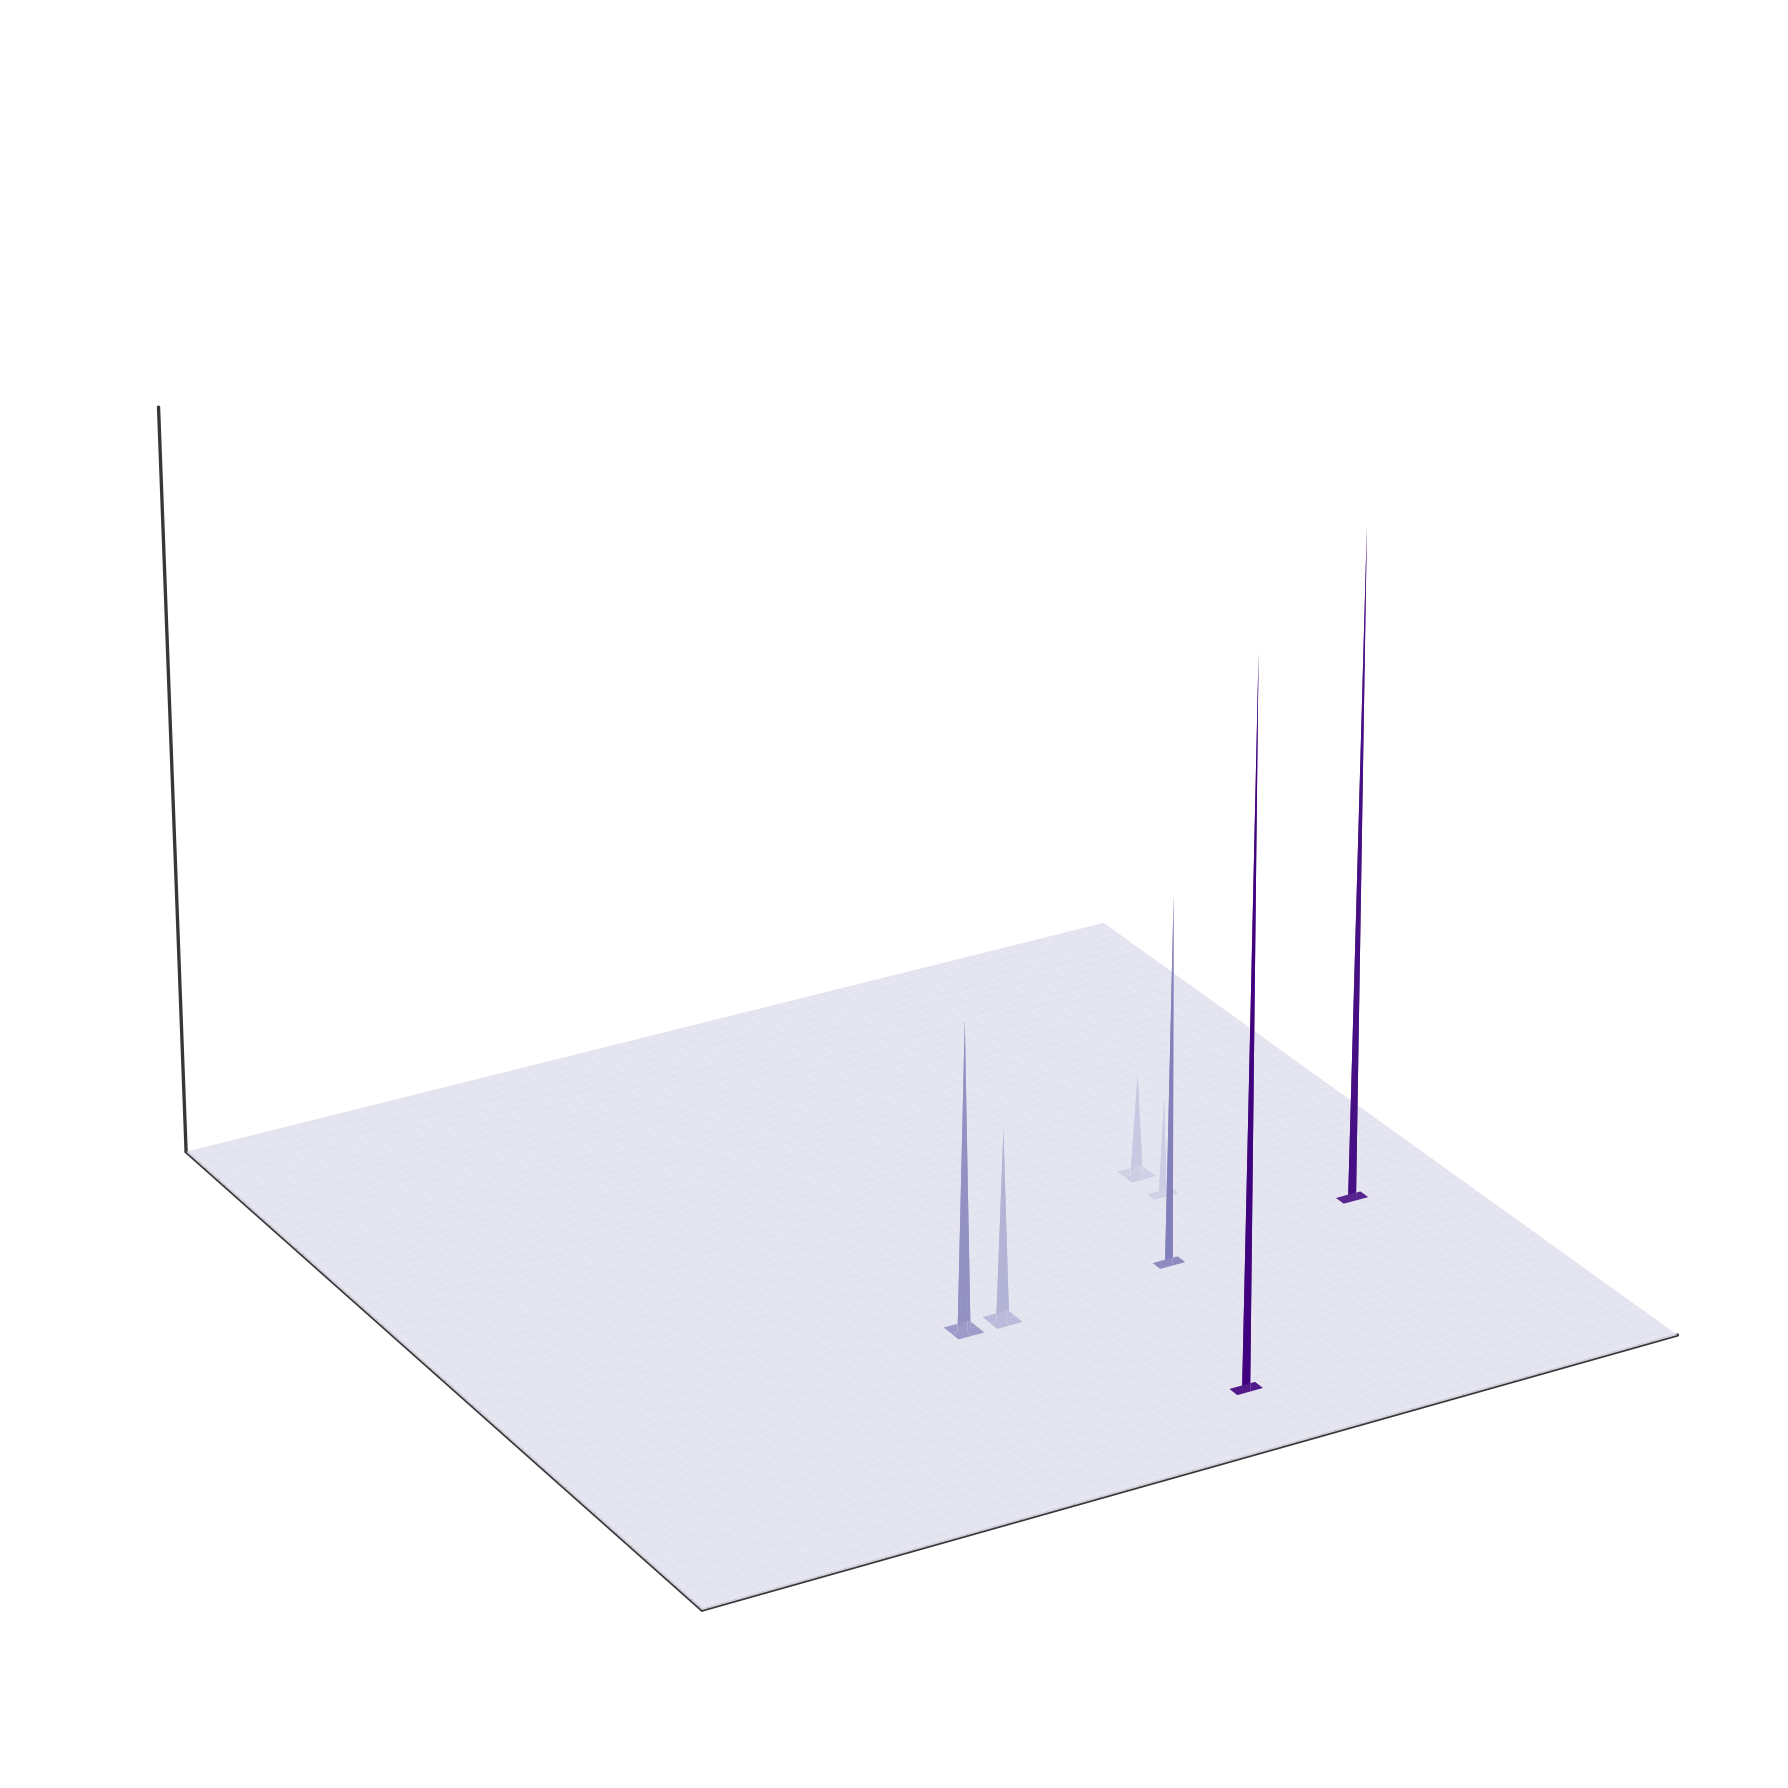

In [244]:
# Set your desired number of peaks here
NUM_PEAKS = 7
SEED = 37967

# Example usage
X, Y, Z, heights, pos_x, pos_y = create_sparse_peak_landscape(num_peaks=NUM_PEAKS, seed=SEED)
plot_landscape(X, Y, Z, cmap='purples', alias=True)

In [338]:
import numpy as np

def create_smooth_hilly_surface(
        x_range=(-5, 5),
        y_range=(-5, 5),
        grid_size=150,
        n_modes=4,                  # how many Fourier components to mix
        amp_range=(0.1, 0.3),       # amplitude of each mode
        freq_range=(0.5, 0.8),      # smaller = longer wavelength
        seed=None):                 # <-- reproducibility key
    """
    Generate a smooth 2-D surface with rolling hills and valleys using a
    few random Fourier modes.

    Parameters
    ----------
    seed : int or None
        If an int is given, the same surface is produced every time the
        function is called with that seed value.

    Returns
    -------
    X, Y, Z : (grid_size, grid_size) ndarrays suitable for plot_surface().
    """
    rng = np.random.default_rng(seed)          # reproducible RNG

    # Grid -------------------------------------------------------------------
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)

    # Start with a flat surface ---------------------------------------------
    Z = np.zeros_like(X, dtype=float)

    # Add random low-frequency sine / cosine modes --------------------------
    for _ in range(n_modes):
        kx = rng.uniform(*freq_range) * rng.choice([-1, 1])   # random sign
        ky = rng.uniform(*freq_range) * rng.choice([-1, 1])
        phase = rng.uniform(0, 2 * np.pi)
        amp   = rng.uniform(*amp_range)

        Z += amp * np.sin(kx * X + ky * Y + phase)

    Z -= Z.mean()  # centre the height around zero
    return X, Y, Z

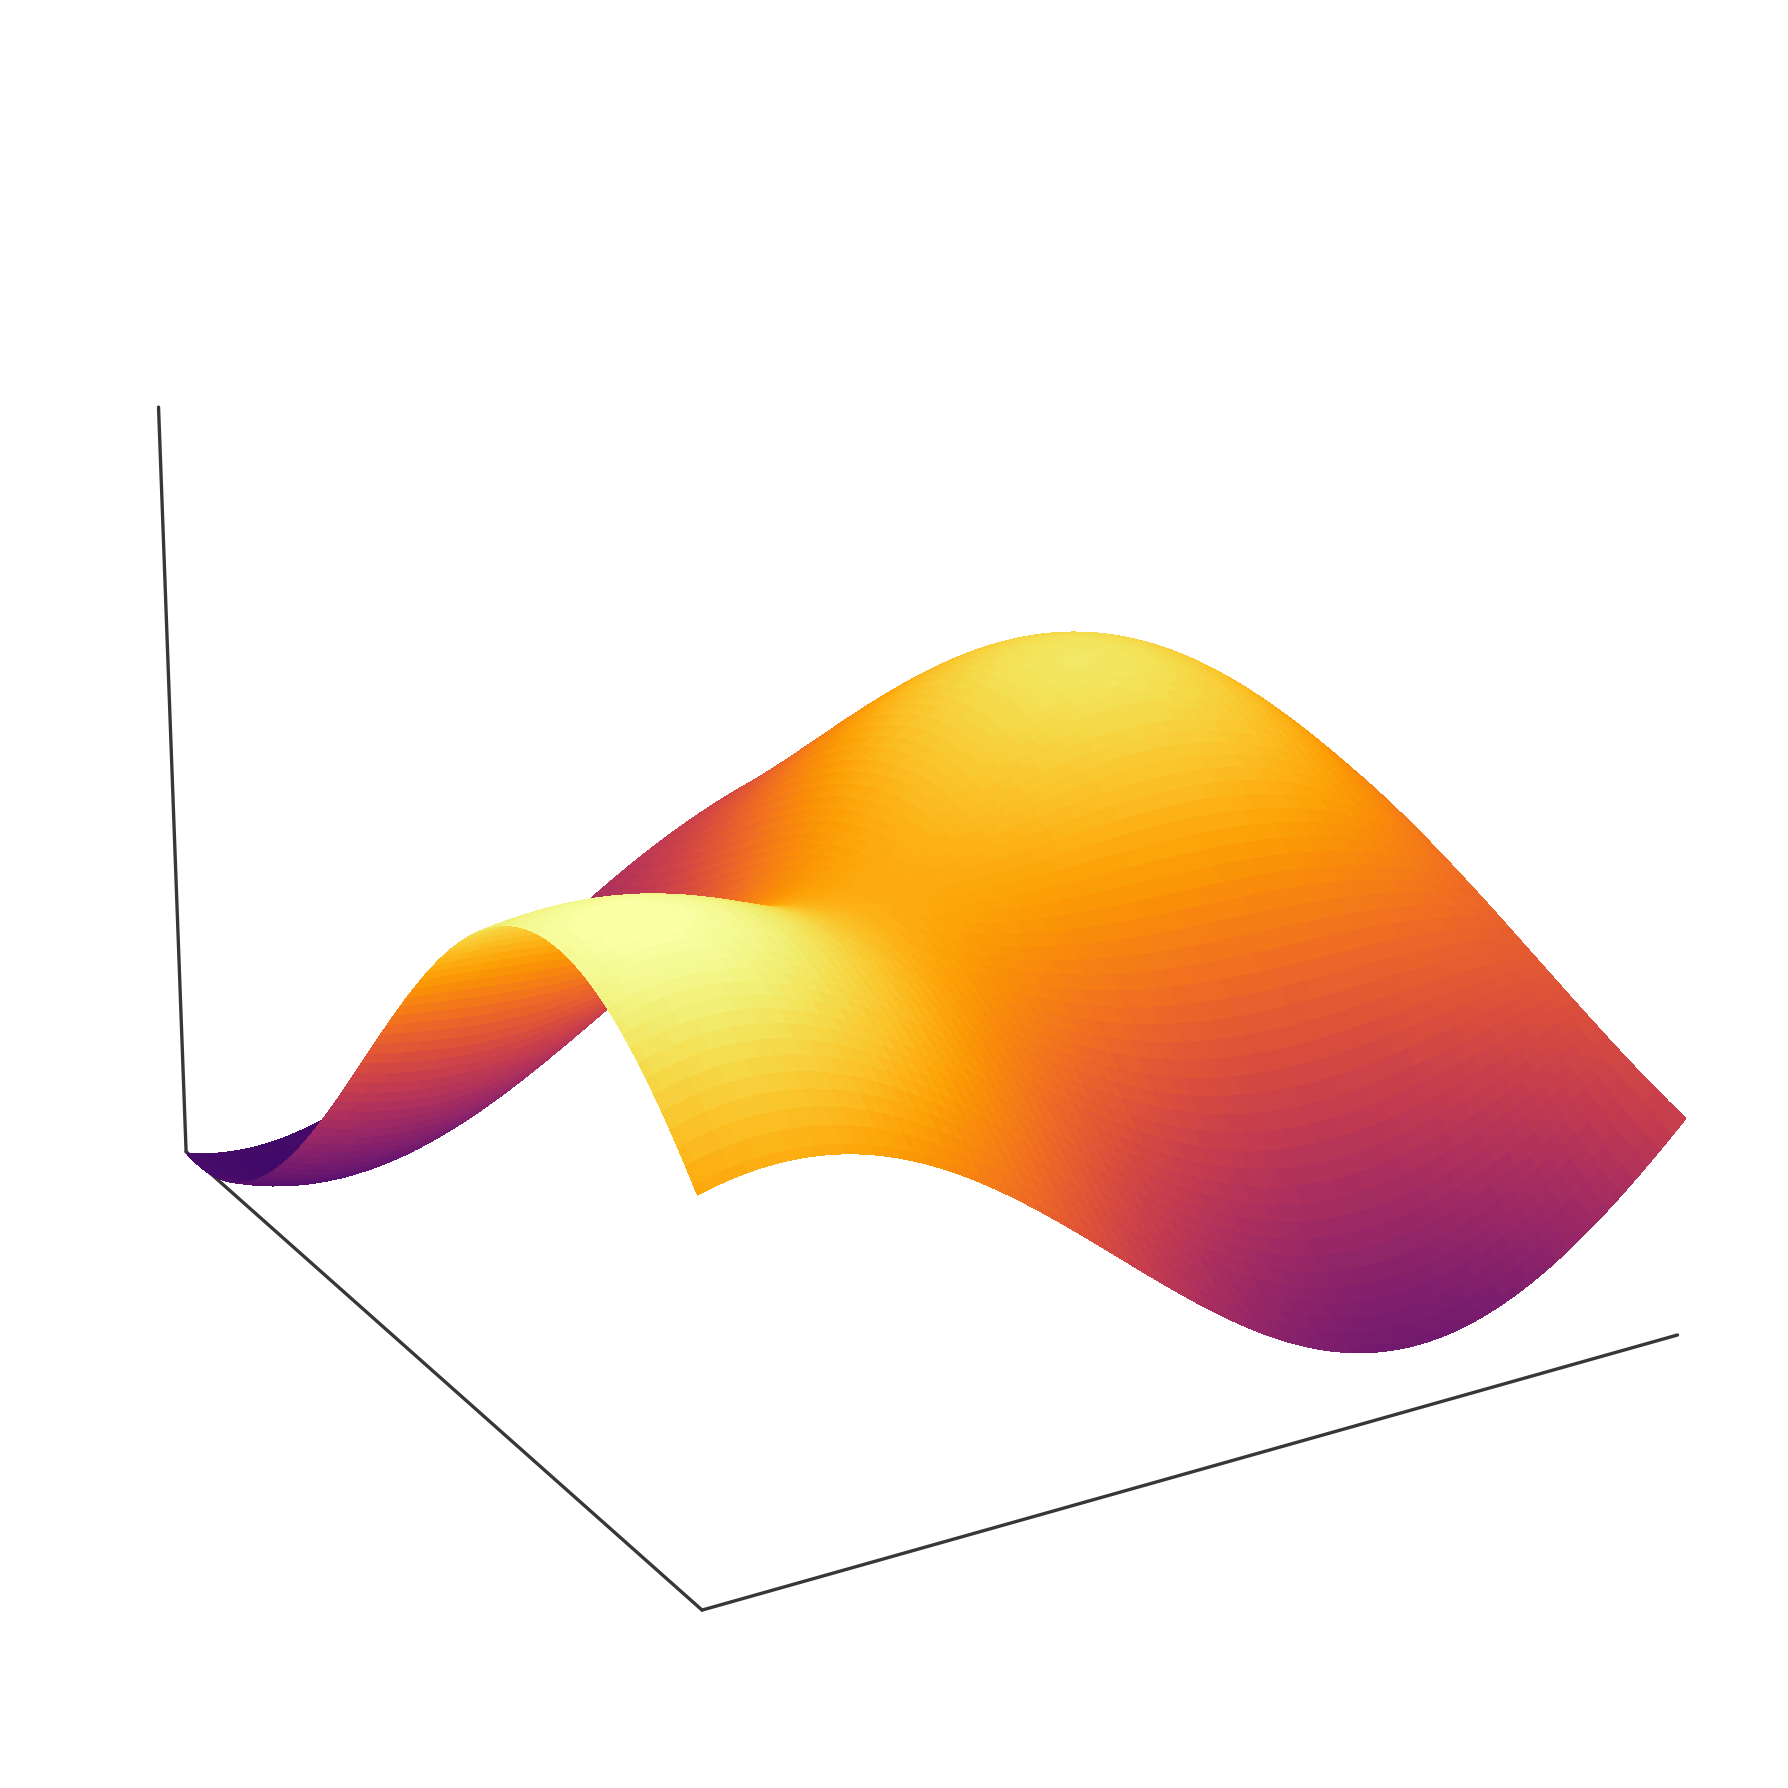

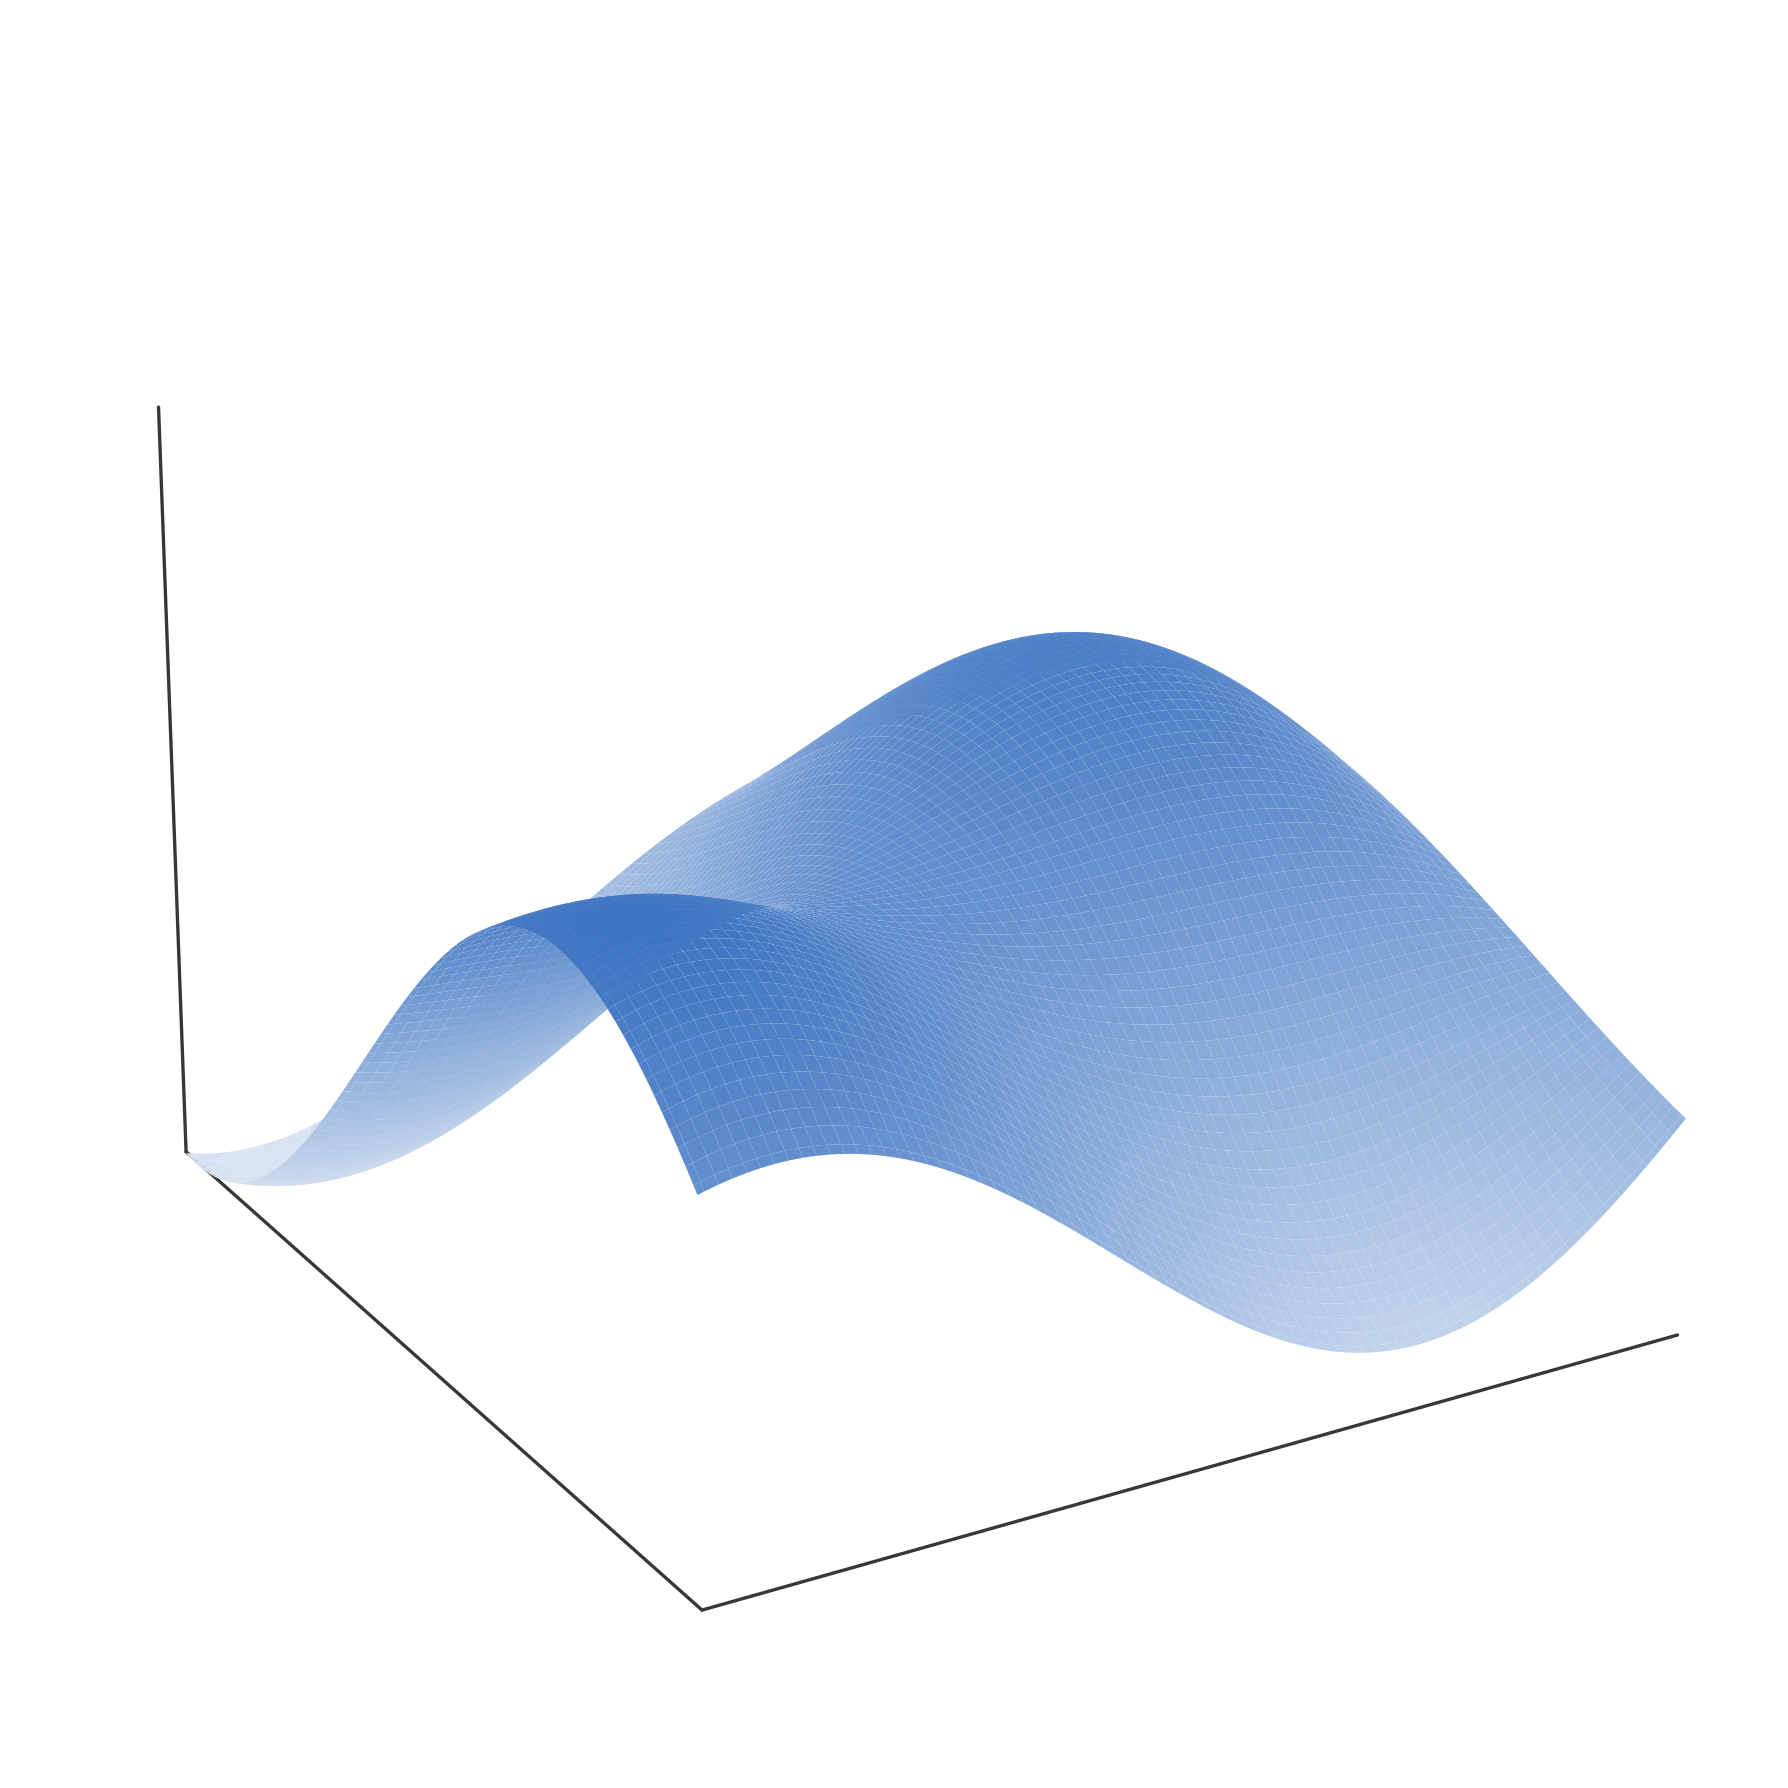

In [344]:
# Set your desired number of peaks here
SEED = 2

# Example usage
X, Y, Z = create_smooth_hilly_surface(seed=349, n_modes=3, amp_range=(0.2, 0.4), freq_range=(0.2, 0.5))
plot_landscape(X, Y, Z, cmap=plt.colormaps.get_cmap('inferno'), alias=False)
plot_landscape(X, Y, Z, cmap=blue_cmap, alias=True)

## f2

In [39]:
def plot_combined_heatmap_params(csv_path_heatmap, csv_path_params, title_suffix=""):
    """
    Create combined plot with sensitivity/efficiency heatmaps and parameter grid.
    
    Parameters:
    - csv_path_heatmap: path to CSV file with performance data
    - csv_path_params: path to CSV file with parameter data
    - title_suffix: optional suffix for the title
    """
    # Read both datasets
    df_perf = pd.read_csv(csv_path_heatmap)
    df_params = pd.read_csv(csv_path_params)
    
    # Check required columns
    expected = {"p_pos", "p_neg", "sensitivity", "efficiency"}
    missing = expected.difference(df_perf.columns)
    if missing:
        raise ValueError(f"Performance CSV is missing columns: {sorted(missing)}")

    # Get all unique values and create complete grid
    x_vals = np.sort(df_perf["p_neg"].unique())  # p_neg on x-axis
    y_vals = np.sort(df_perf["p_pos"].unique())  # p_pos on y-axis
    
    # Create all possible combinations (complete grid)
    all_combinations = []
    for y in y_vals:  # p_pos
        for x in x_vals:  # p_neg
            all_combinations.append({'p_pos': y, 'p_neg': x})
    
    complete_grid = pd.DataFrame(all_combinations)
    
    # Merge with original data to fill missing combinations with NaN
    df_complete = complete_grid.merge(df_perf, on=['p_pos', 'p_neg'], how='left')

    # Create figure with 3 subplots (2 heatmaps + 1 parameter grid)
    fig, axs = plt.subplots(1, 3, figsize=(10, 2.8), dpi=300)

    metric_info = {
        "sensitivity": blue_cmap,
        "efficiency": blue_cmap,
    }

    def luminance(rgba):
        r, g, b, _ = rgba
        return 0.299 * r + 0.587 * g + 0.114 * b

    # Plot heatmaps
    for idx, (metric, cmap) in enumerate(metric_info.items()):
        ax = axs[idx]
        
        # Create pivot table with complete grid - swapped index and columns
        z = (df_complete.pivot(index="p_pos", columns="p_neg", values=metric)
                .reindex(index=y_vals, columns=x_vals))
        
        # Create a masked array for missing values
        z_values = z.values.copy()
        mask = np.isnan(z_values)
        
        # Plot the heatmap (only for non-NaN values)
        im = ax.imshow(z_values, origin="lower", cmap=cmap, aspect="equal")

        # Convert to percentage labels for ticks
        x_labels = [f"{x*100:.1f}" if x >= 0.01 else f"{x*100:.2f}" for x in x_vals]  # p_neg
        y_labels = [f"{y*100:.1f}" if y >= 0.01 else f"{y*100:.2f}" for y in y_vals]  # p_pos
        
        # Set ticks with percentage values
        ax.set_xticks(range(len(x_vals)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_vals)))
        ax.set_yticklabels(y_labels)

        # Add numbers inside cells
        norm = im.norm
        for i, y in enumerate(y_vals):  # p_pos
            for j, x in enumerate(x_vals):  # p_neg
                if mask[i, j]:  # Missing value
                    # Fill with white background
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                             facecolor='white', edgecolor='gray'))
                    ax.text(j, i, "n/a", ha="center", va="center", 
                           color='black', fontsize=10)
                else:
                    val = z_values[i, j]
                    rgba = cmap(norm(val))
                    txt_colour = "white" if luminance(rgba) < 0.5 else _new_black
                    ax.text(j, i, f"{val:.3f}",
                            ha="center", va="center", color=txt_colour, fontsize=10)
        
    # Plot parameter grid
    ax_params = axs[2]
    
    # Set white background and limits - SAME AS HEATMAPS
    ax_params.set_facecolor('white')
    ax_params.set_xlim(-0.5, len(x_vals)-0.5)
    ax_params.set_ylim(-0.5, len(y_vals)-0.5)
    
    # Set the same aspect ratio as the heatmaps
    ax_params.set_aspect('equal')
    
    # Set ticks with percentage values
    x_labels = [f"{x*100:.1f}" if x >= 0.01 else f"{x*100:.2f}" for x in x_vals]  # p_neg
    y_labels = [f"{y*100:.1f}" if y >= 0.01 else f"{y*100:.2f}" for y in y_vals]  # p_pos
    
    ax_params.set_xticks(range(len(x_vals)))
    ax_params.set_xticklabels(x_labels, rotation=90)
    ax_params.set_yticks(range(len(y_vals)))
    ax_params.set_yticklabels(y_labels)
    
    # Add grid lines
    ax_params.set_xticks(np.arange(-0.5, len(x_vals), 1), minor=True)
    ax_params.set_yticks(np.arange(-0.5, len(y_vals), 1), minor=True)
    ax_params.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Add parameter combinations to each cell
    for i, p_pos in enumerate(y_vals):  # p_pos is y-axis
        for j, p_neg in enumerate(x_vals):  # p_neg is x-axis
            # Find the row for this p_pos/p_neg combination
            row = df_params[(df_params['p_pos'] == p_pos) & (df_params['p_neg'] == p_neg)]
            
            if not row.empty:
                pool_size = int(row['pool_size'].iloc[0])
                num_meet = int(row['num_meet'].iloc[0])
                num_redun = int(row['num_redun'].iloc[0])
                
                # Create the parameter label
                param_text = f"({pool_size}, {num_meet}, {num_redun})"
                
                # Add parameter text (centered in cell)
                ax_params.text(j, i, param_text, ha="center", va="center", 
                       color='black', fontsize=10, weight='bold')
            else:
                ax_params.text(j, i, "n/a", ha="center", va="center", 
                       color='red', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    return

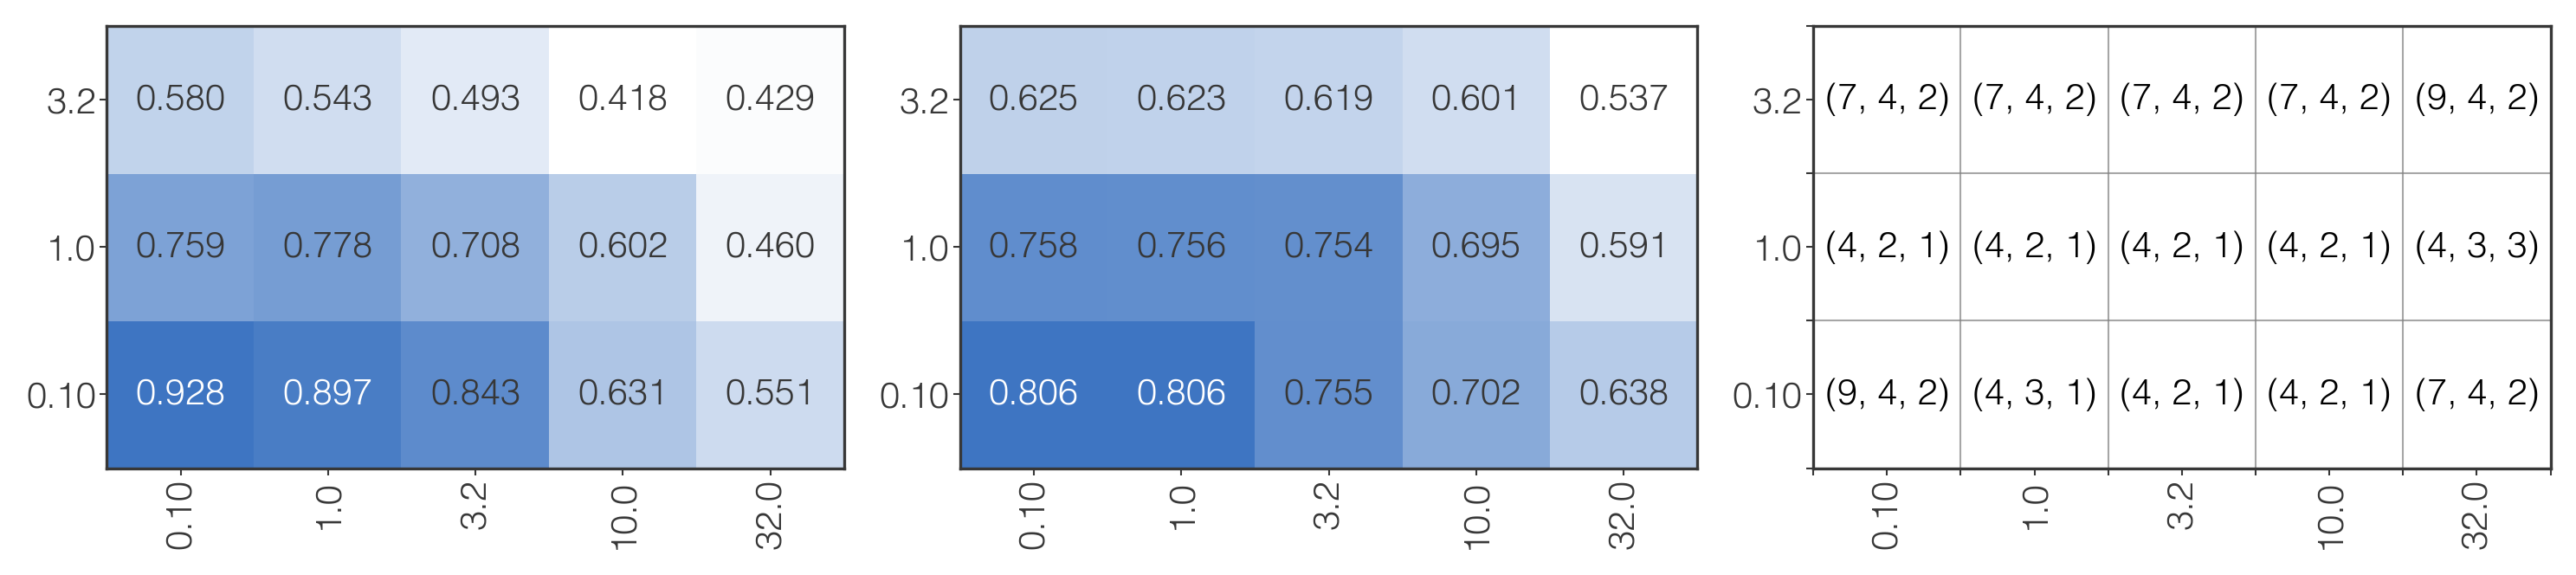

In [40]:
jun_grid = plot_combined_heatmap_params('/home/msh_yi/research/multicat/batch_inputs_jobs/50_jun_grid/done/agg_sensitivity_efficiency_coop_trunc.csv', '/home/msh_yi/research/multicat/batch_inputs_jobs/50_jun_grid/done/top_params_sensitivity_coop_trunc.csv')

In [6]:
import pandas as pd

# ---- settings --------------------------------------------------------------
infile  = '/home/msh_yi/research/multicat/analysis/res/f2b_ls_50_02_22_1_coop_mat.csv'   # your original file
outfile = '/home/msh_yi/research/multicat/analysis/res/f2b_ls_50_02_22_1_coop_mat_zero.csv'  # file to write the result to
# ---------------------------------------------------------------------------

# read the two–column CSV exactly as it is (no header present)
df = pd.read_csv(infile, header=None)

# column 1 (index 1) is the numeric column – subtract 1
df[1] = df[1] - 1

# write the modified dataframe back without header or index
df.to_csv(outfile, header=False, index=False)

/home/msh_yi/research/multicat/analysis/res/f2c_ls_sample_70_merck_batch_1_03_01_ls_0_coop_mat.csv


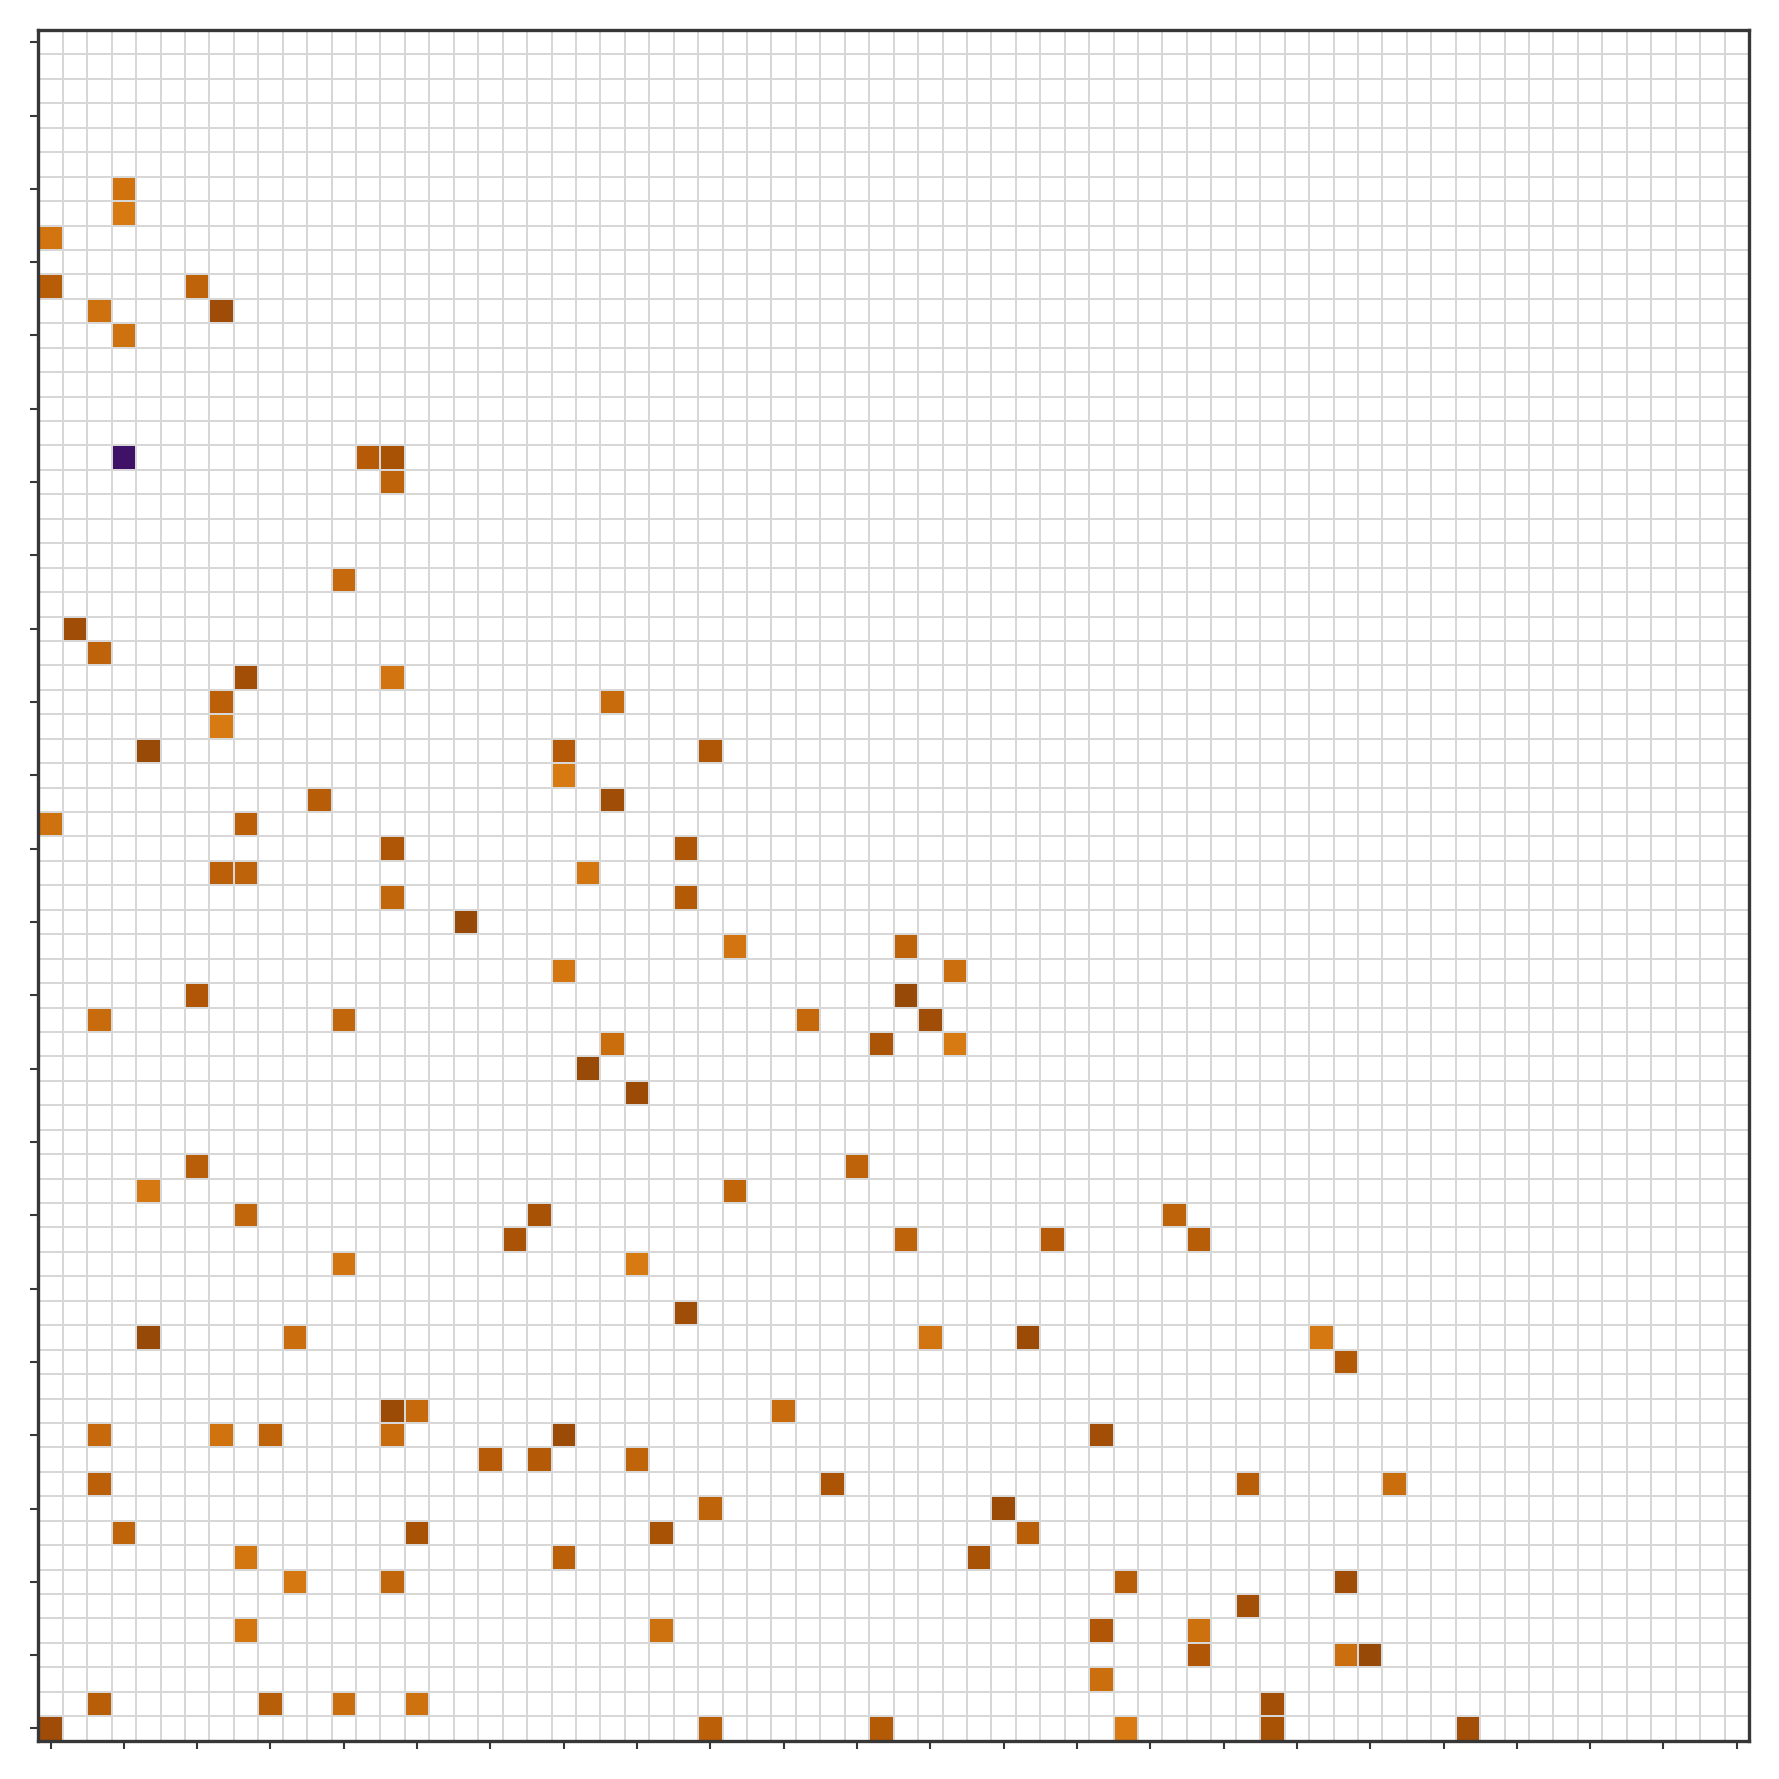

In [359]:
files = ['/home/msh_yi/research/multicat/analysis/res/f2c_ls_sample_70_merck_batch_1_03_01_ls_0_coop_mat.csv']

for f in files:
    print(f)
    viz_coop_zero_center(70, f, simple=True)

[False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False  True False  True False False False
  True False  True False  True False False False  True False False  True
 False  True False False  True False False False False  True False False
  True False False False]


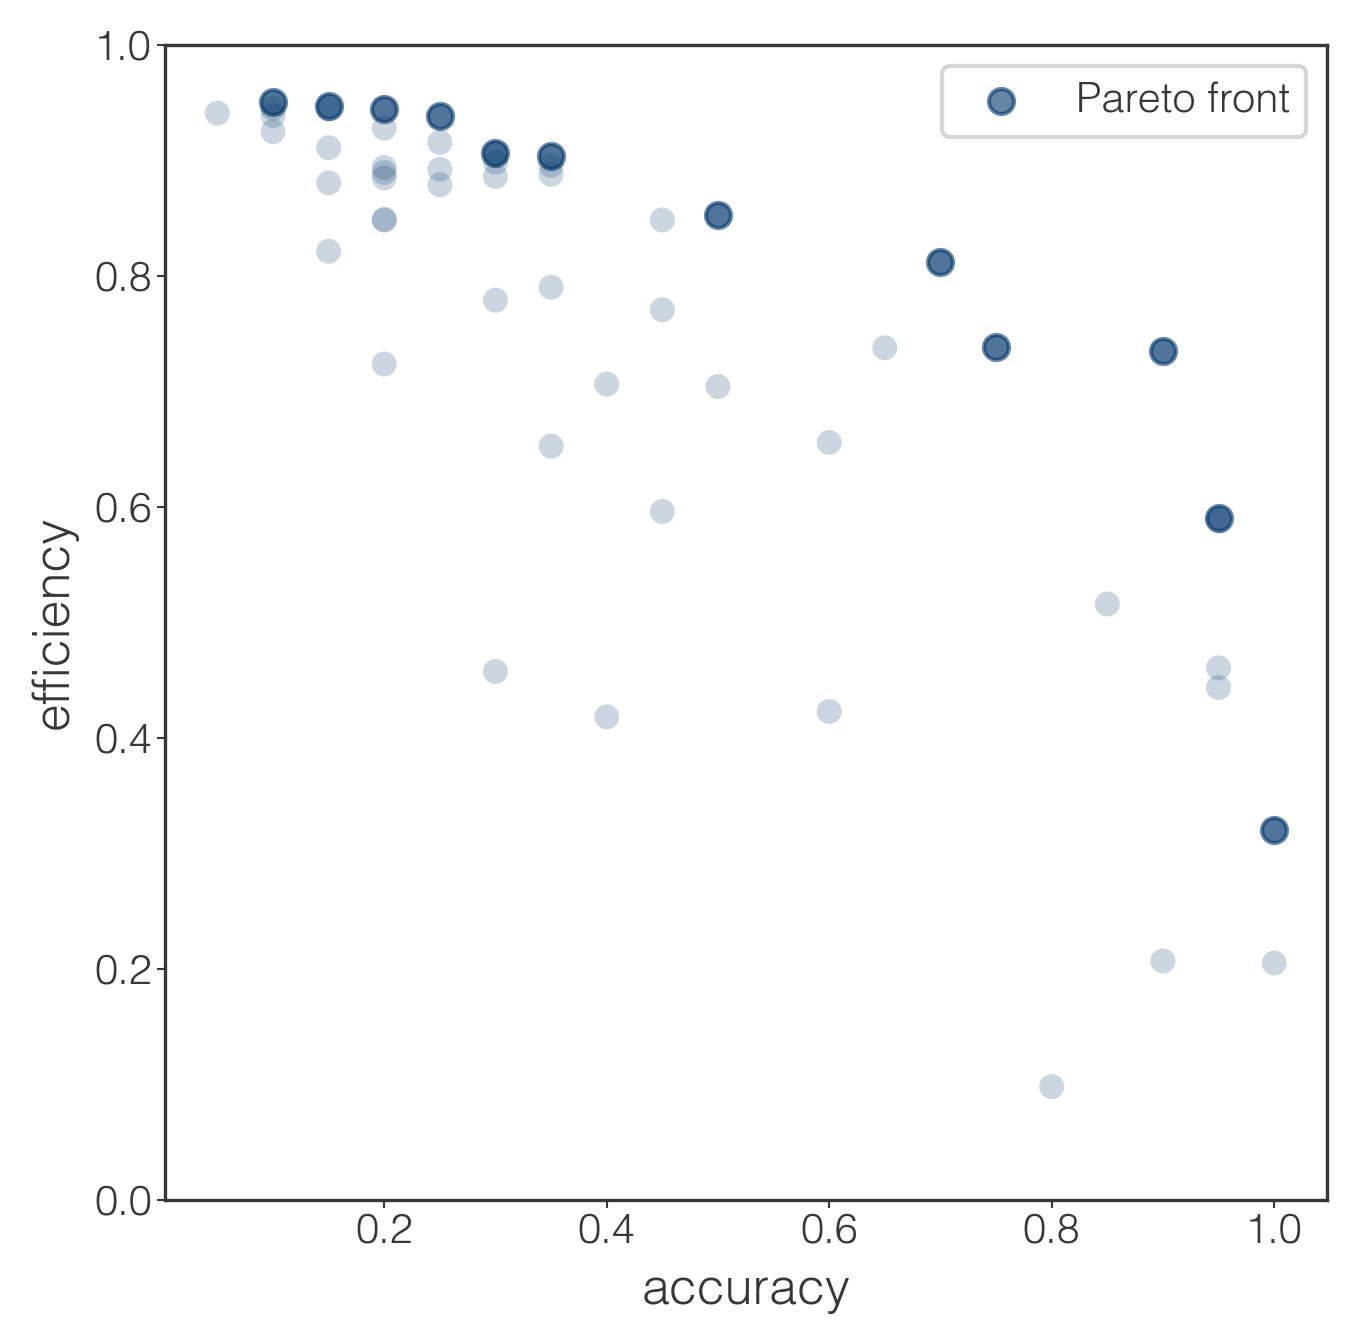

In [16]:
files = ['/home/msh_yi/research/multicat/analysis/res/50_os_06_06_1_extract.csv']
plot_tradeoffs(files, 1225, 'accuracy', 'total pools', ['accuracy'], title=None, plot_pareto=True)

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False  True False False False False
 False False  True False False  True False False False False False  True
 False  True False False False False False  True False  True False False
  True False False False False False False False False False False False
  True False False False  True False False False False False False False
 False False False False False  True False False False False  True False]


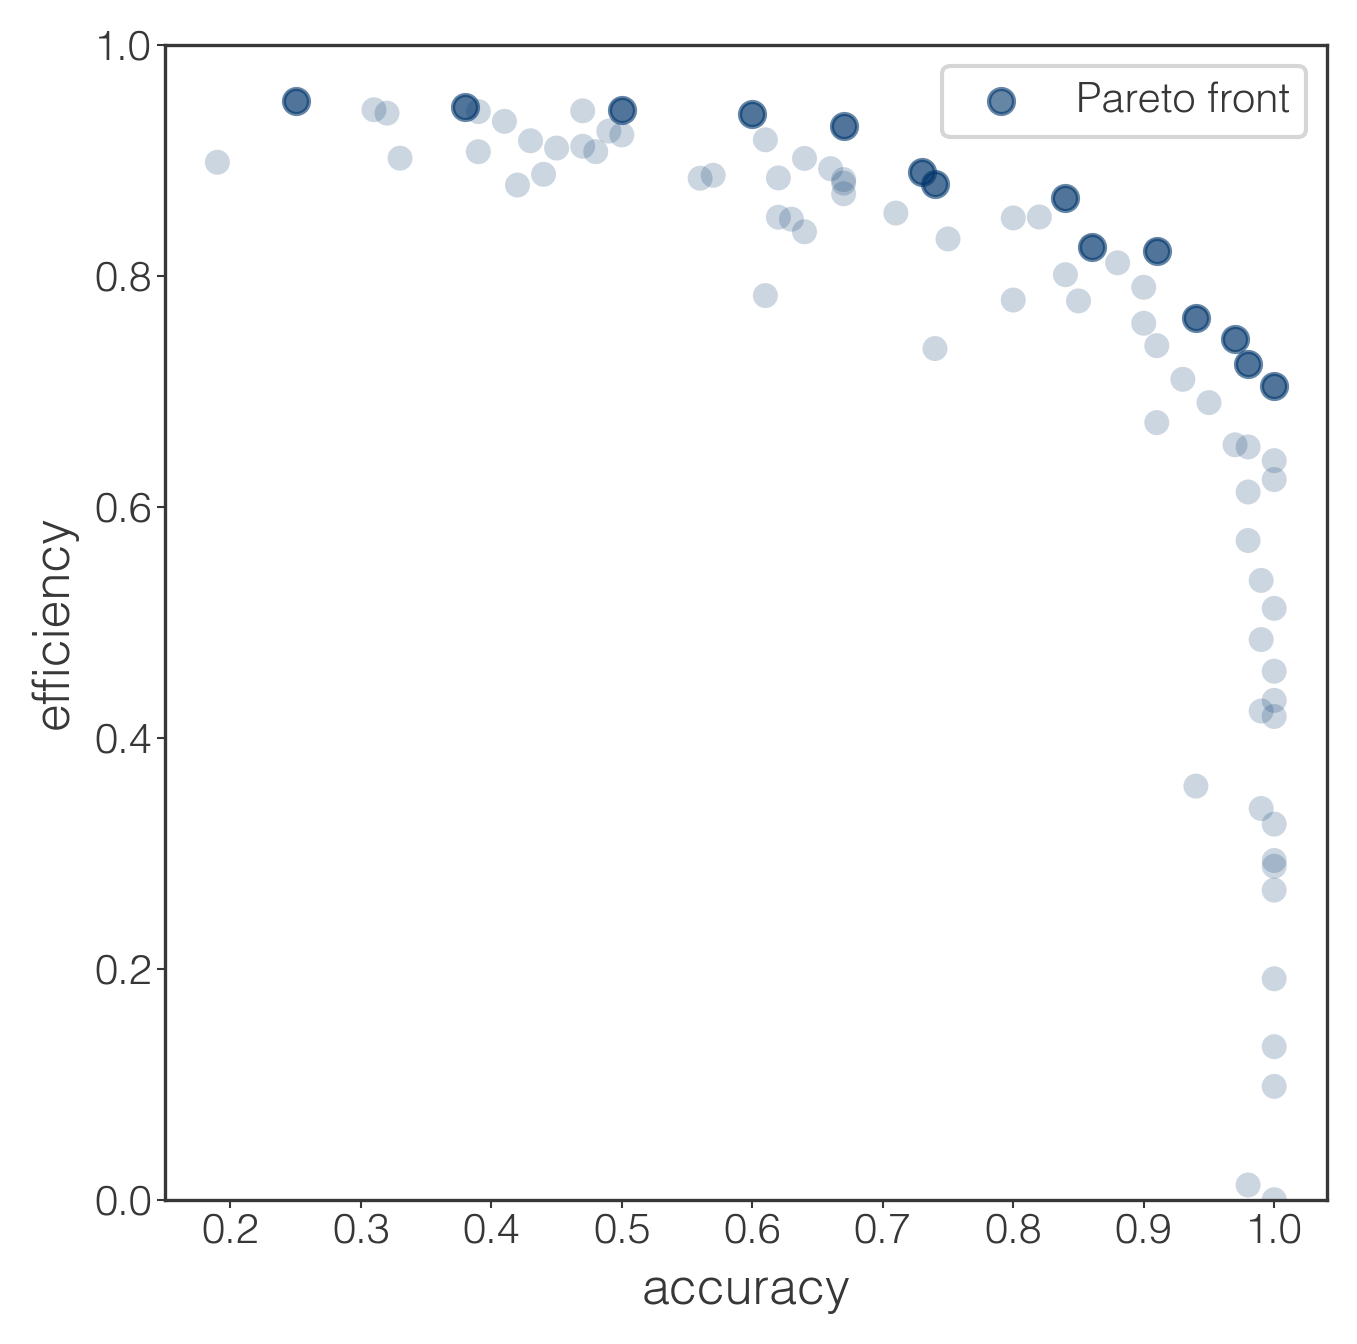

In [366]:
files = ['/home/msh_yi/research/multicat/analysis/res/50_batch_1_09_16_9.out.csv']
plot_tradeoffs(files, 1225, 'accuracy', 'num_pools', ['accuracy'], title=None, plot_pareto=True)

# f3

[ 3.98333333  2.44555556 13.83777778  1.07666667  0.71333333  4.66555556
  4.28555556  1.1         1.78666667  0.81555556  3.77111111]


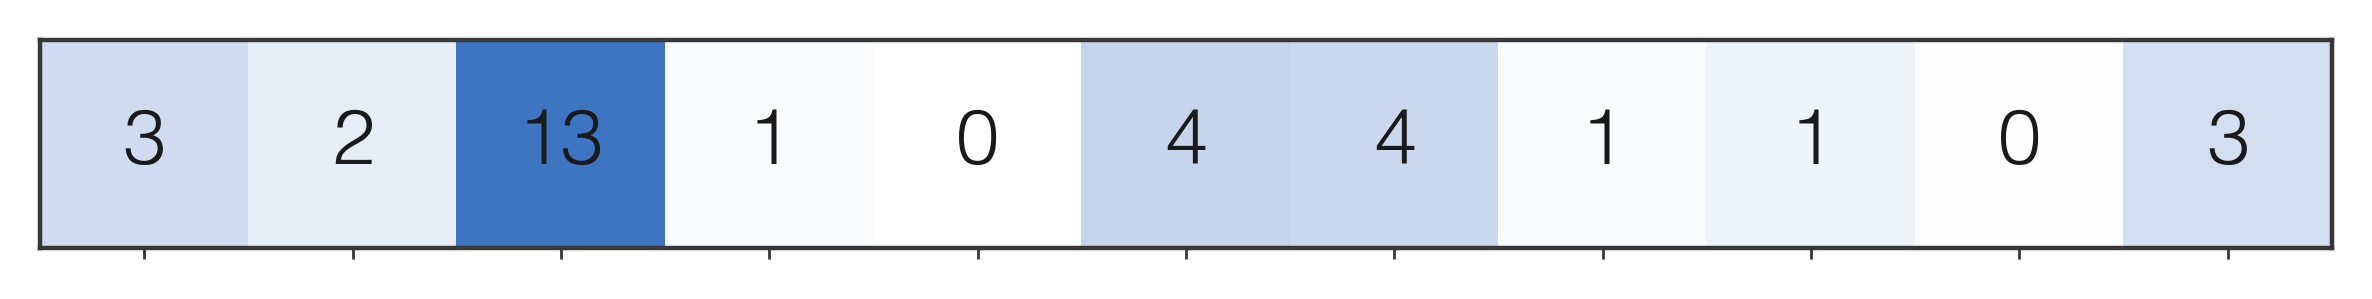

In [36]:
x_labels=['1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1j', '1k']
visualize_cats('/home/msh_yi/research/multicat/validation/expt_inputs/11_06_05_1_cat_rate.csv', x_labels=None)

/tmp/ipykernel_74781/844387507.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[(<Figure size 1320x1320 with 1 Axes>,
  <Figure size 120x1320 with 1 Axes>,
  <Figure size 120x1320 with 1 Axes>),
 (<Figure size 1320x480 with 1 Axes>,
  <Figure size 120x480 with 1 Axes>,
  <Figure size 120x480 with 1 Axes>)]

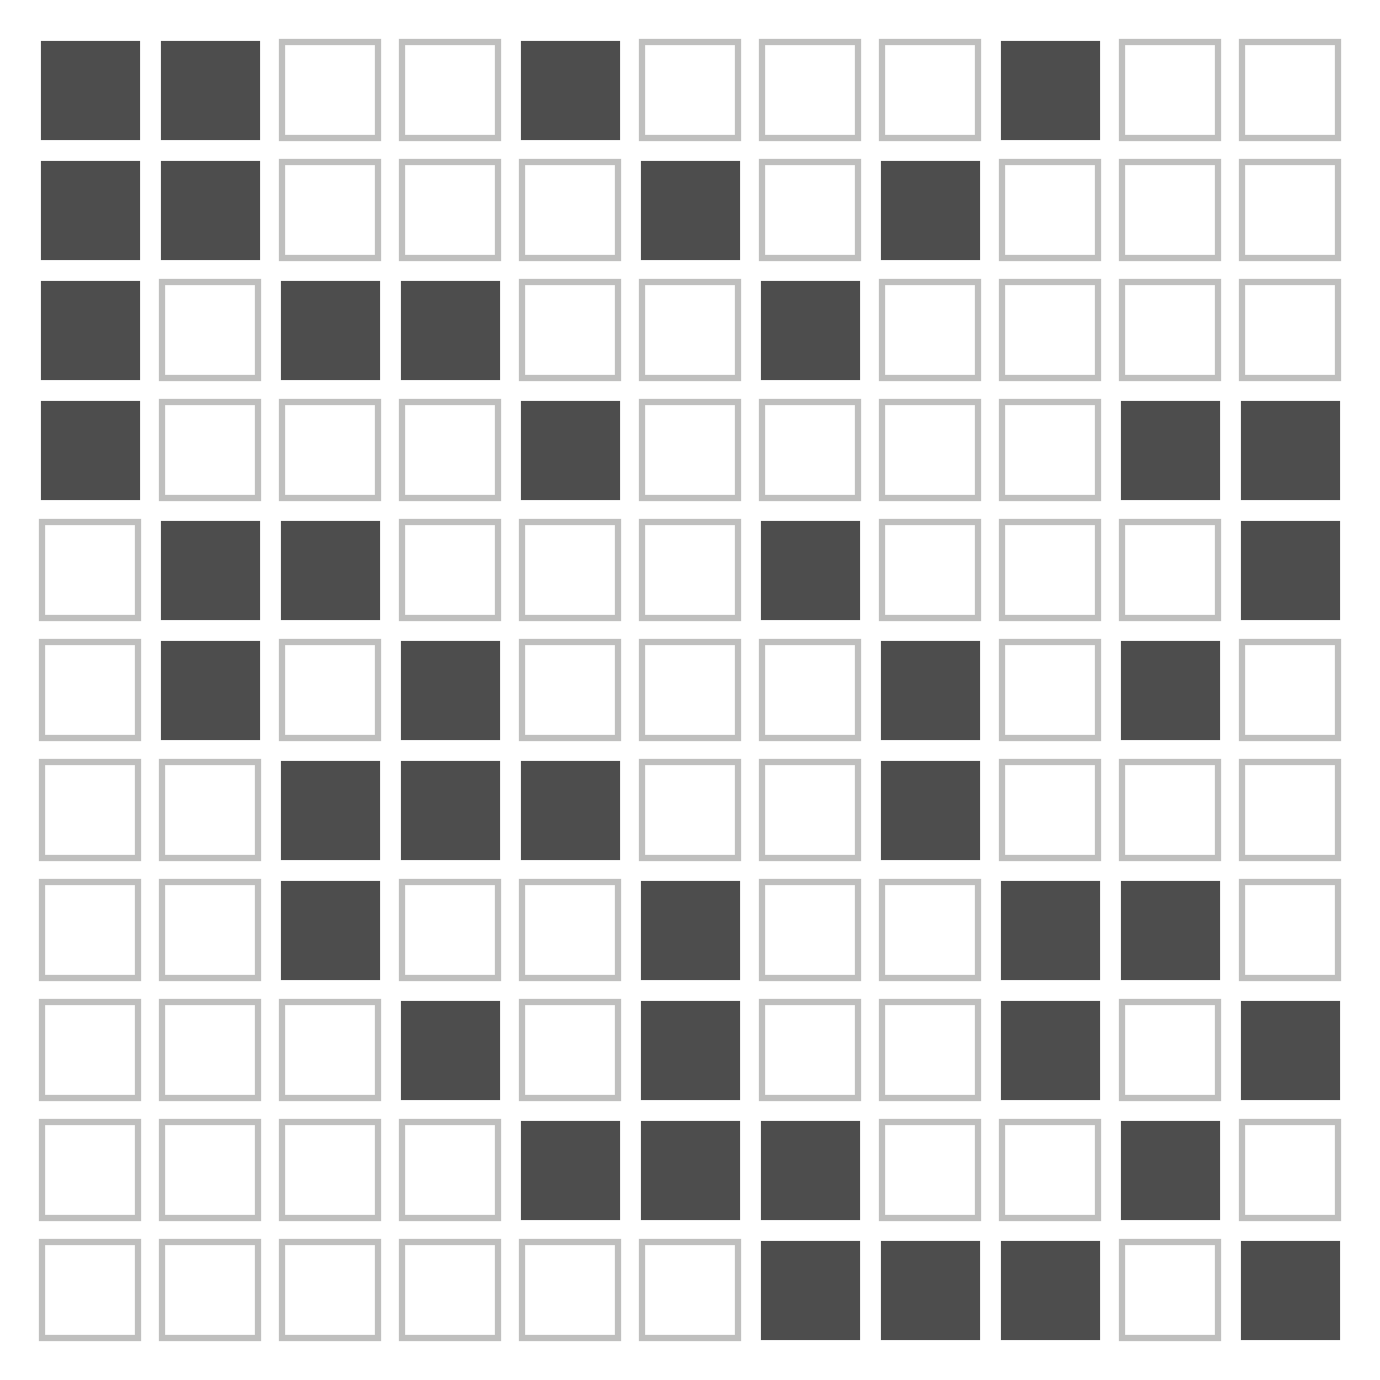

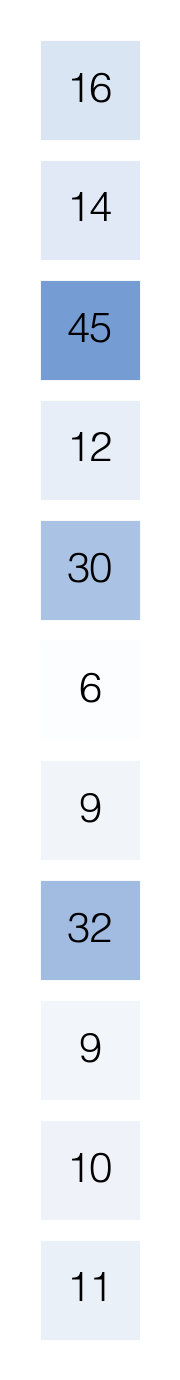

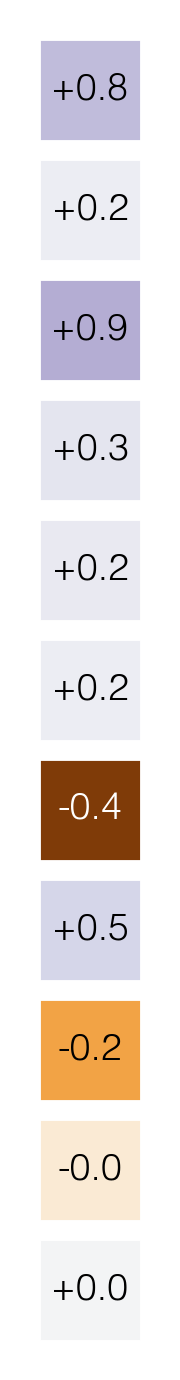

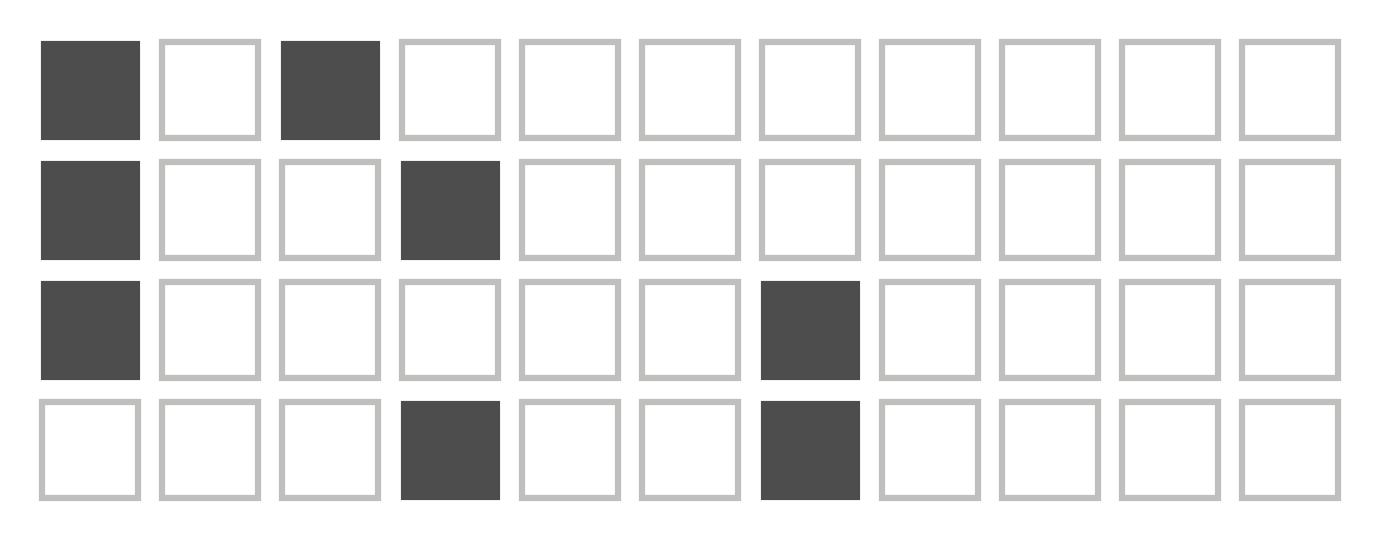

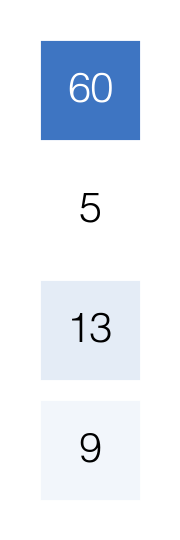

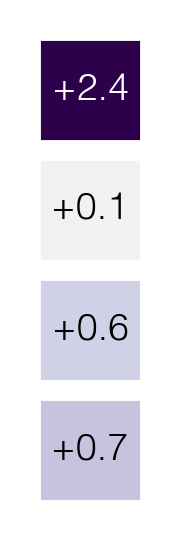

In [8]:
plot_oneshot_expt('/home/msh_yi/research/multicat/validation/expt_inputs/rec_11_06_05_compiled_merge_06_10_25.csv', cell_size=0.4)

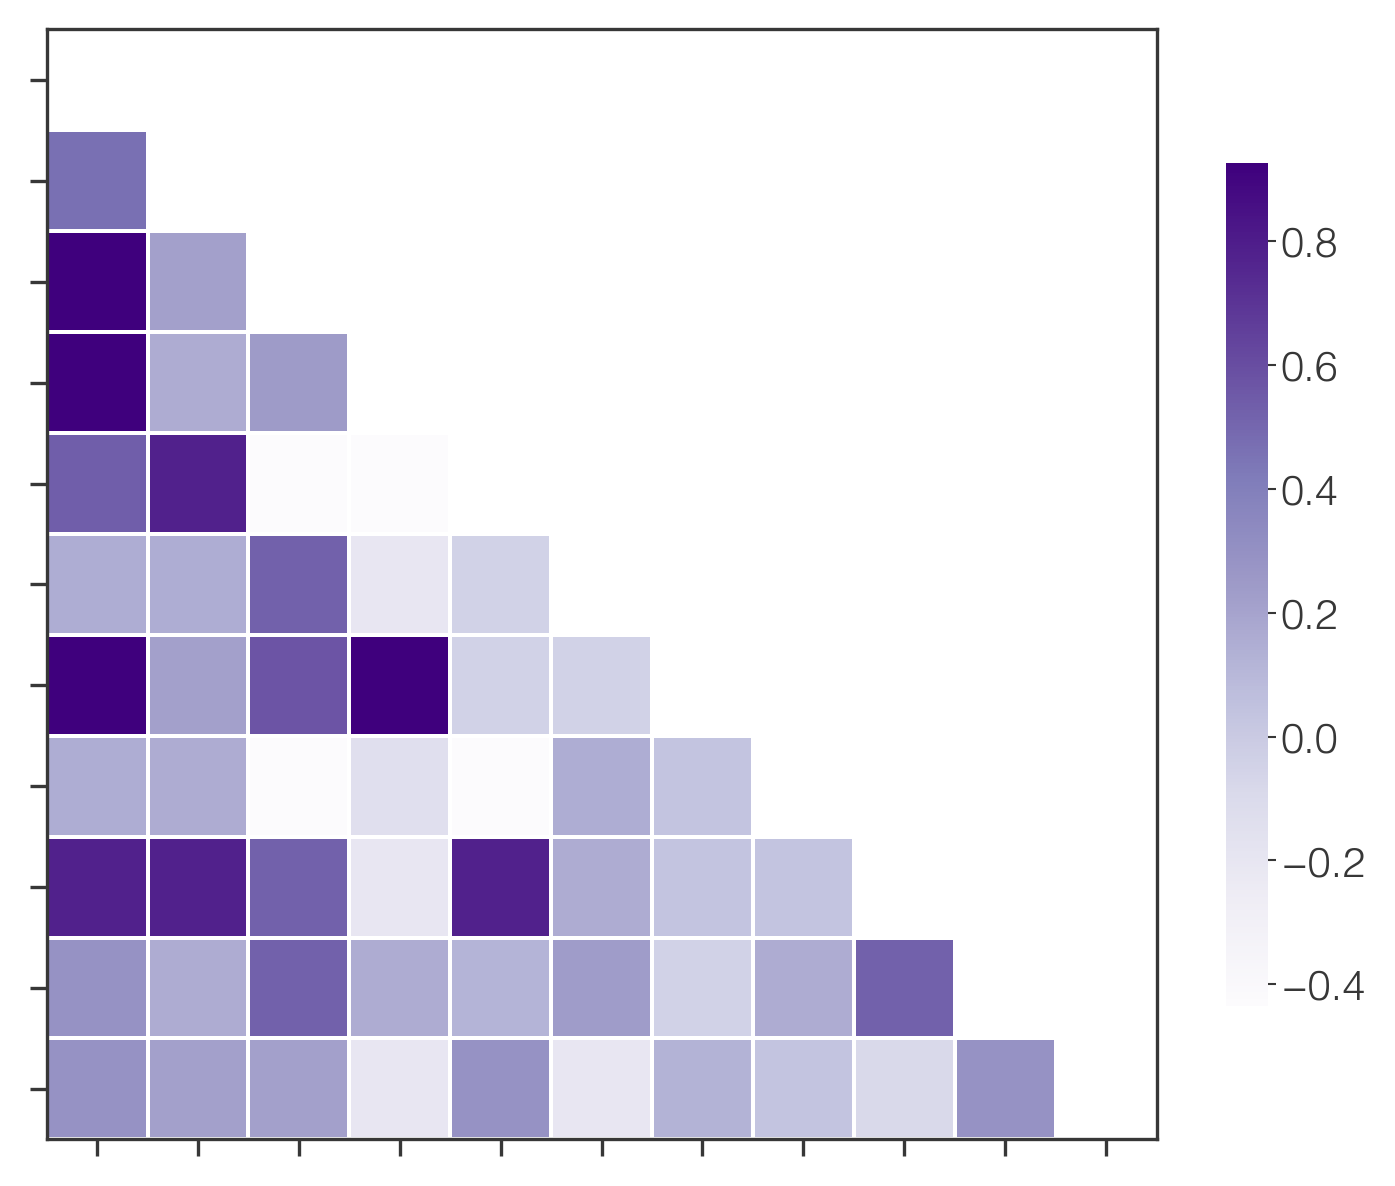

In [19]:
viz_deconv_score_pairs('/home/msh_yi/research/multicat/analysis/res/f3b_deconv_score_pairs.csv', inner_lw=0.5, tickmarks=True)

# f4

In [3]:
# swarm plot of singles yields
# 1. Data preparation
# -------------------------------------------------------------
def load_and_prepare(csv_path):
    """
    Read the CSV and pull out a numeric pool identifier.
    Expects columns called 'pool' and 'output'.
    """
    df = pd.read_csv(csv_path)

    # Extract pool numbers such as “…[17]…” → 17
    df['pool_num'] = df['cat'].apply(
        lambda x: int(re.search(r'\[(\d+)\]', str(x)).group(1))
                  if re.search(r'\[(\d+)\]', str(x)) else x)

    df['output'] = pd.to_numeric(df['output'], errors='coerce')
    return df


# -------------------------------------------------------------
# 2a. Swarm plot (+ thin box summary)
# -------------------------------------------------------------
def plot_swarm(df):
    """
    Horizontal swarm (beeswarm) with a thin vertical box overlay.
    • dot colour  #3e75c2
    • no grid lines
    • black frame
    • honours whatever seaborn theme is already active
    """
    fig, ax = plt.subplots(figsize=(6, 1), dpi=300)

    # Dummy categorical column so swarm/box both plot on single row
    df_plot = df.copy()
    df_plot['row'] = ''          # all points share the same y-category

    sns.swarmplot(
        x='output',
        y='row',
        data=df_plot,
        color='#3e75c2',
        size=5,
        ax=ax
    )

    sns.boxplot(
        x='output',
        y='row',
        data=df_plot,
        width=.25,
        showcaps=False,
        boxprops={'facecolor':'white', 'edgecolor':_new_black},
        showfliers=False,
        whiskerprops={'linewidth':0},
        ax=ax
    )

    # Axis labelling
    ax.set_ylabel('')
    ax.set_xlabel('yield (%)')
    #ax.set_title('Catalyst yields – horizontal swarm plot')

    # Remove the single y-tick that would otherwise appear
    ax.set_yticks([])

    # No grid for this axis
    ax.grid(False)

    # Ensure black frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(_new_black)
        spine.set_linewidth(1)

    return fig



# -------------------------------------------------------------
# 2b. Cleveland dot plot (horizontal, sorted)
def plot_cleveland(df):
    sns.set(style='white')

    df_sorted = df.sort_values('output').reset_index(drop=True)
    y_pos = np.arange(len(df_sorted))

    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

    # Light stems
    ax.hlines(y=y_pos,
              xmin=0,
              xmax=df_sorted['output'],
              color='lightgrey',
              linewidth=1)

    # Dots
    ax.scatter(df_sorted['output'], y_pos,
               color='steelblue', s=35, zorder=3)

    ax.set_xlabel('yield (%)')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_sorted['pool_num'])     # remove if too crowded
    #ax.set_title('Catalyst yields – Cleveland dot plot')
    ax.grid(axis='x', linestyle='--', alpha=.4)
    ax.set_ylim(-1, len(df_sorted))               # small padding

    return fig


/home/msh_yi/anaconda3/envs/combi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/msh_yi/anaconda3/envs/combi/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/msh_yi/anaconda3/envs/combi/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


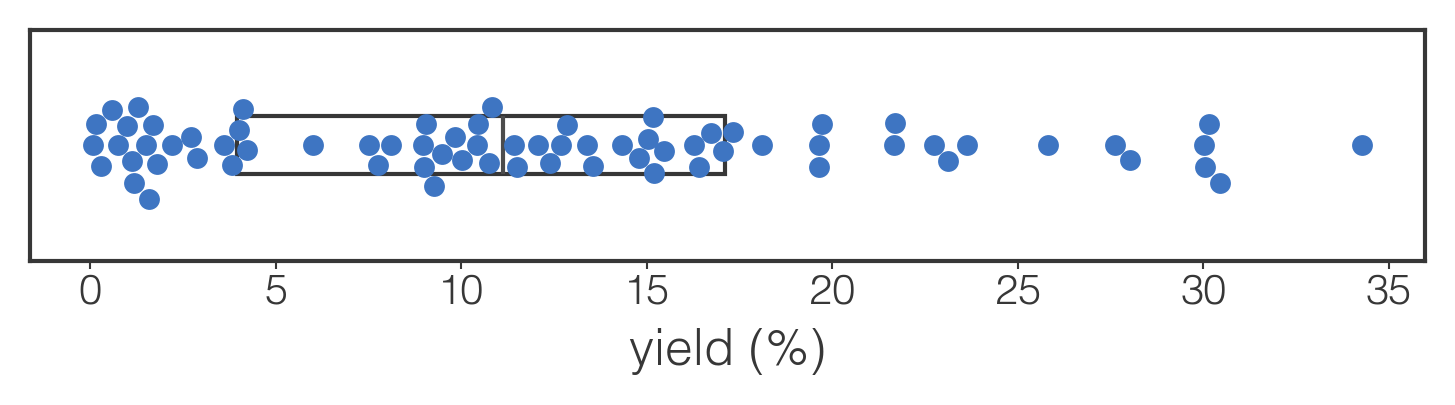

In [4]:
csv_file = '/home/msh_yi/research/coop/hte/analysis/PAR-EXP-78-81_agg/80_singles_biaryl_y.csv'      # your file
df = load_and_prepare(csv_file)

plot_swarm(df)
#plot_cleveland(df)
plt.show()

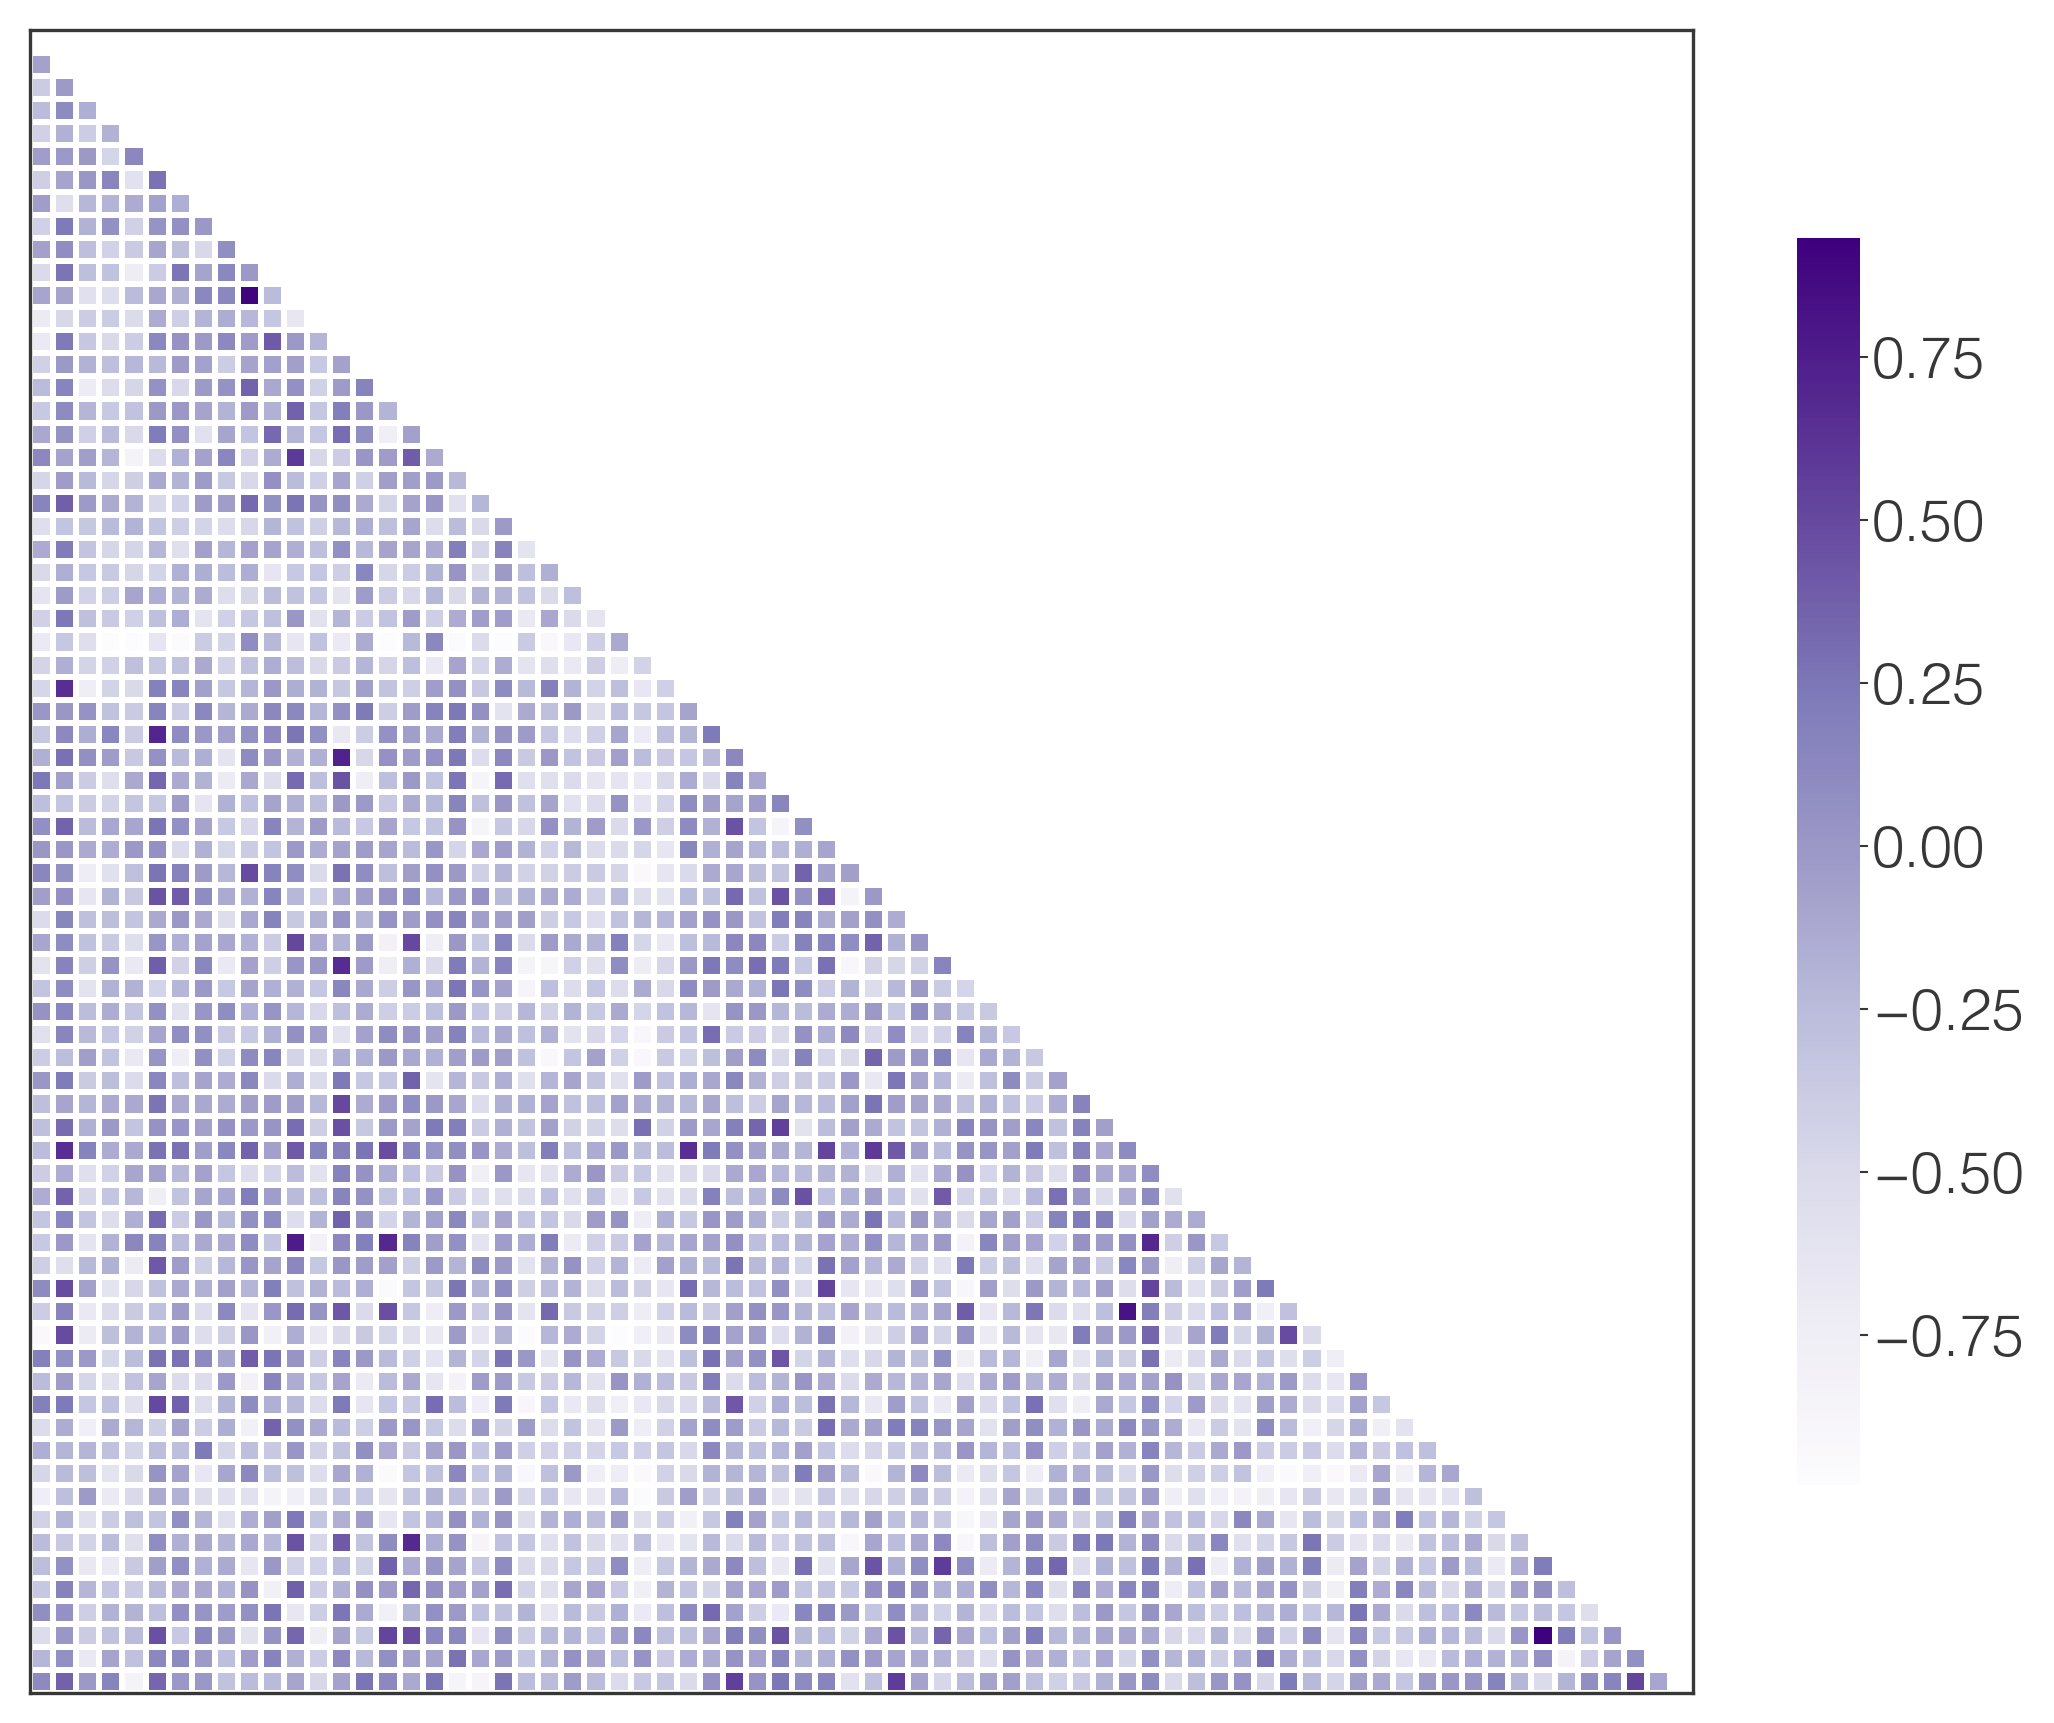

In [24]:
viz_deconv_score_pairs('/home/msh_yi/research/coop/hte/analysis/PAR-EXP-78-81_agg/79_deconv_pairs_ref_80_max.csv', cell_size=0.1, inner_lw=1)
plt.show()

In [30]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_coop_by_rank(df, deconv_df,
                      cutoff=48,
                      color_left='#5a3098',
                      color_right='#e69f00',
                      figsize=(11, 1.8), dpi=300):

    # 1. pool → rank (0 = best score)
    deconv_df = deconv_df.copy()
    deconv_df['pool'] = deconv_df['pool'].astype(str)
    ranks = (
        deconv_df.sort_values('score', ascending=False)
                 .reset_index(drop=True)
                 .assign(rank=lambda d: d.index)
                 .set_index('pool')['rank']
    )

    # 2. merge rank into experimental dataframe
    df = df.copy()
    df['pool'] = df['pool'].astype(str)
    df['rank'] = df['pool'].map(ranks)
    df_sorted = df.sort_values('rank').reset_index(drop=True)

    # 3. colour vector (using 0-based rank for cutoff logic)
    colours = df_sorted['rank'].apply(
        lambda r: color_left if r < cutoff else color_right
    )

    # 4. plot (add 1 to rank for display)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.scatter(df_sorted['rank'] + 1, df_sorted['coop'],  # +1 for display
               c=colours, alpha=0.8, s=35, edgecolor='none')
    ax.axvline(cutoff + 1, color='#777777', linestyle='--', linewidth=0.8)  # +1 for display

    # y-axis ticks 0,2,4,6,8
    ax.set_yticks([0, 2, 4, 6, 8])

    # 5. ensure ticks at 1 and at cutoff+1 (49), but remove 0
    ticks = list(ax.get_xticks())
    display_cutoff = cutoff + 1
    
    # Remove tick at 0 if present
    if 0 in ticks:
        ticks.remove(0)
    
    # Add tick at 1 and at cutoff if not present
    for tick_pos in [1, display_cutoff]:
        if tick_pos not in ticks:
            ticks.append(tick_pos)
    
    ax.set_xticks(sorted(ticks))

    # 6. cosmetics
    for spine in ax.spines.values():
        spine.set_visible(True)
        #spine.set_color(_new_black)
        spine.set_linewidth(1)
    ax.grid(False)
    ax.set_xlim(0, (df_sorted['rank'].max() + 1) * 1.005)  # +1 for display
    ax.set_ylim(-0.5, 10)

    plt.tight_layout()
    plt.show()

    return df_sorted

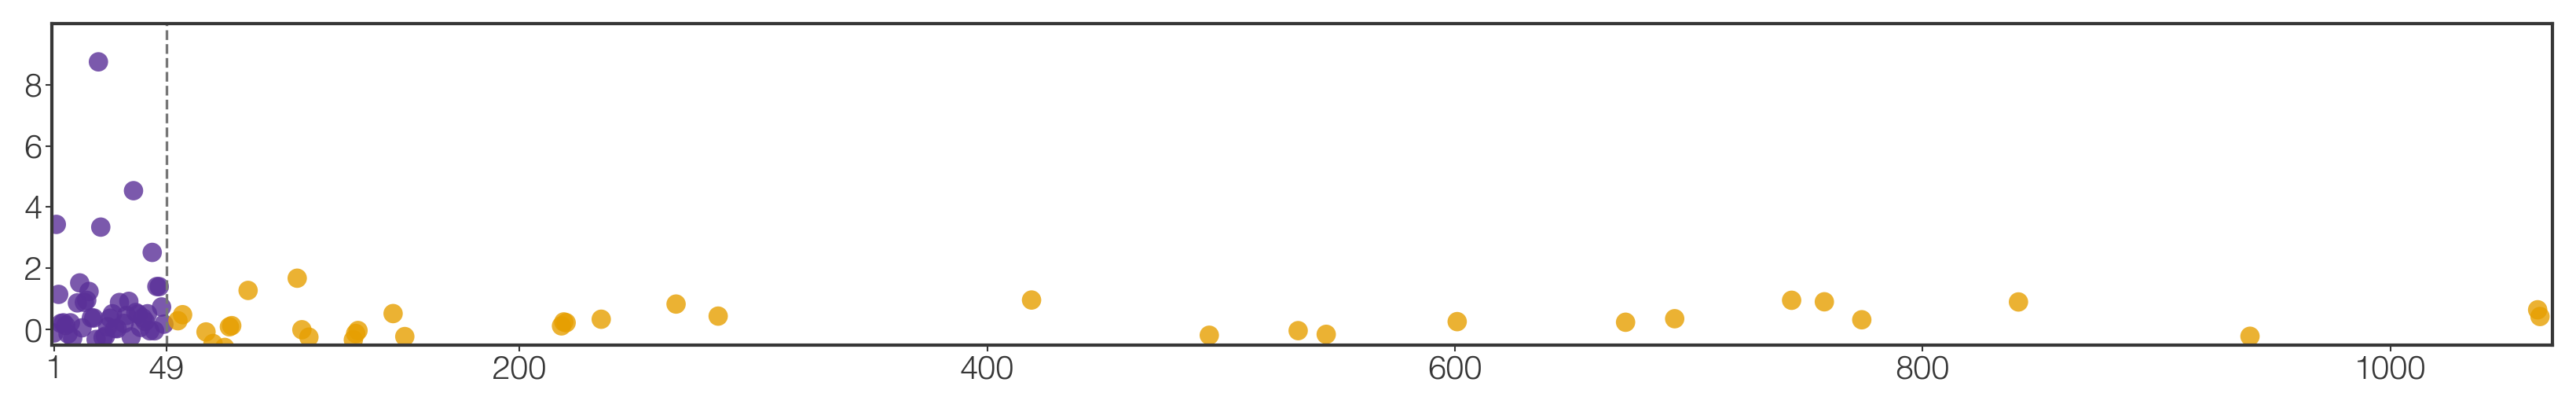

In [31]:
# Call the function
df = pd.read_csv('/home/msh_yi/research/coop/hte/analysis/PAR-EXP-78-81_agg/combined_80_deconv_max_coop_max.csv')
deconv_df = pd.read_csv('/home/msh_yi/research/coop/hte/analysis/PAR-EXP-78-81_agg/79_deconv_pairs_ref_80_max.csv')
sorted_df = plot_coop_by_rank(df, deconv_df)

# SI

In [ ]:
infiles = '/n/home10/msak/multicat/batch_inputs_jobs/50_jun_grid/done/50_jun_grid_05_pos0p32_neg0p001/out/*csv'
N = 50
metric_column = 'mean_sensitivity'
report_params='/n/home10/msak/multicat/batch_inputs_jobs/50_jun_grid/done/50_jun_grid_05_pos0p32_neg0p001/batch_param_extract_sens.csv'

viz_batch_optim(infiles, N, metric_column, beta=1, viz_dist=True, plt_agg=False, report_params=False)